# Introduction
In this project, I create Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) and Bayesian Structural Time Series (BSTS) models to forecast the daily number of visitors at restaurants. This notebook is part 2 of a two-notebook project on the [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting) dataset provided by Recruit Holdings, and in this notebook I perform data preparation, time series analysis, and modeling on the dataset. [Part 1](https://github.com/michellekli/visitor-forecasting/blob/master/visitor-forecasting-part1.ipynb) covers exploratory data analysis and data cleaning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.2)
import hvplot.pandas
import geoviews as gv

from scipy.stats import chisquare
import math

import ruptures as rpt
import pmdarima as pm
from pydlm import dlm, trend, seasonality, autoReg
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import vfplot as vfp
import vfmodel as vfm
import vfdata as vfd

# Load data


In [2]:
df = vfd.get_prepared_data()
df.head()

air_store_id visit_date  visitors  air_genre_name  \
0  air_00a91d42b08b08d9 2016-07-01        35  Italian/French   
1  air_00a91d42b08b08d9 2016-07-02         9  Italian/French   
2  air_00a91d42b08b08d9 2016-07-04        20  Italian/French   
3  air_00a91d42b08b08d9 2016-07-05        25  Italian/French   
4  air_00a91d42b08b08d9 2016-07-06        29  Italian/French   

                     air_area_name   latitude   longitude prefecture  \
0  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
1  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
2  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
3  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
4  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   

         city               city-area  
0  Chiyoda-ku  Chiyoda-ku Kudanminami  
1  Chiyoda-ku  Chiyoda-ku Kudanminami  
2  Chiyoda-ku  Chiyoda-ku Kudanminami  
3  Chiyoda-ku  Chiyoda-ku Kudanminami  
4  Chiyoda-ku  Chiyoda-ku Kudanminami

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 10 columns):
air_store_id      252108 non-null object
visit_date        252108 non-null datetime64[ns]
visitors          252108 non-null int64
air_genre_name    252108 non-null object
air_area_name     252108 non-null object
latitude          252108 non-null float64
longitude         252108 non-null float64
prefecture        252108 non-null object
city              252108 non-null object
city-area         252108 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 19.2+ MB


# Examine the most common restaurants
In the previous notebook, we found that the most common restaurants are Izakaya and Cafe/Sweets types in the Shibuya and Shibakōen areas of the Shibuya-ku and Minato-ku cities within Tōkyō-to prefecture. I will focus on these types of restaurants moving forward, and I will create a pipeline for modeling visitors to the store with the most data available and the store with the least data available.

In [4]:
assert (df.loc[vfd.get_majority_store(df), 'air_store_id'].nunique() ==
        df.loc[(df['prefecture'] == 'Tōkyō-to') & 
           (df['city'].isin(['Shibuya-ku', 'Minato-ku'])) &
           (df['city-area'].isin(['Shibuya-ku Shibuya', 'Minato-ku Shibakōen'])) &
           (df['air_genre_name'].isin(['Izakaya', 'Cafe/Sweets']))
           , 'air_store_id'].nunique())

In [5]:
df.loc[vfd.get_majority_store(df), :].groupby(by='air_store_id').size().sort_values(ascending=False)

air_store_id
air_5c817ef28f236bdf    477
air_a8533b7a992bb0ca    454
air_fd6aac1043520e83    381
air_b9e27558fb8bd5c4    379
air_86cfbf2624576fad    344
air_55390f784018349a    338
air_5ed3198e4a5eed0f    331
air_e0118664da63a2d0    330
air_7bc6ca04d7b0f3b8    310
air_2f8ced25216df926    290
air_e34c631c766f2766    287
air_710d6537cb7623df    287
air_efd70b04de878f25    278
air_af24e3e817dea1e5    275
air_c6ffd6a93e6b68d6    270
air_10713fbf3071c361    269
air_6902e4ec305b3d08    257
air_f6bfd27e2e174d16    251
air_87ca98aa7664de94    249
air_a11473cc1eb9a27f    244
air_ffcc2d5087e1b476    243
air_ebd31e812960f517    239
air_9483d65e9cc9a6b7    233
air_96929a799b12a43e    231
air_d69b08a175bc0387    213
air_b30fffd7ab1e75a5    202
air_c66dbd2c37832d00    198
dtype: int64

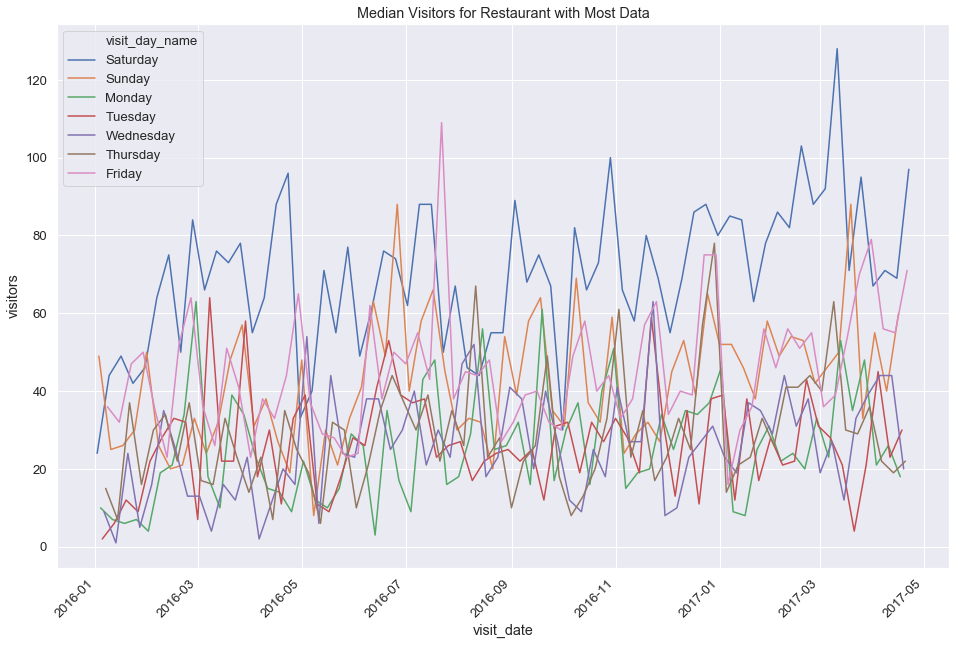

In [6]:
most_df = vfp.plot_median_visitors_daily(df.loc[df['air_store_id'] == 'air_5c817ef28f236bdf', :], stores_subset=None,
                               title='Median Visitors for Restaurant with Most Data')

In [7]:
most_df.groupby(by='visit_day_name').median()

visitors  visit_dow
visit_day_name                     
Friday              42.0        4.0
Monday              23.0        0.0
Saturday            71.0        5.0
Sunday              40.0        6.0
Thursday            26.0        3.0
Tuesday             26.0        1.0
Wednesday           24.5        2.0

There seems to be a difference in median visitors by day name.

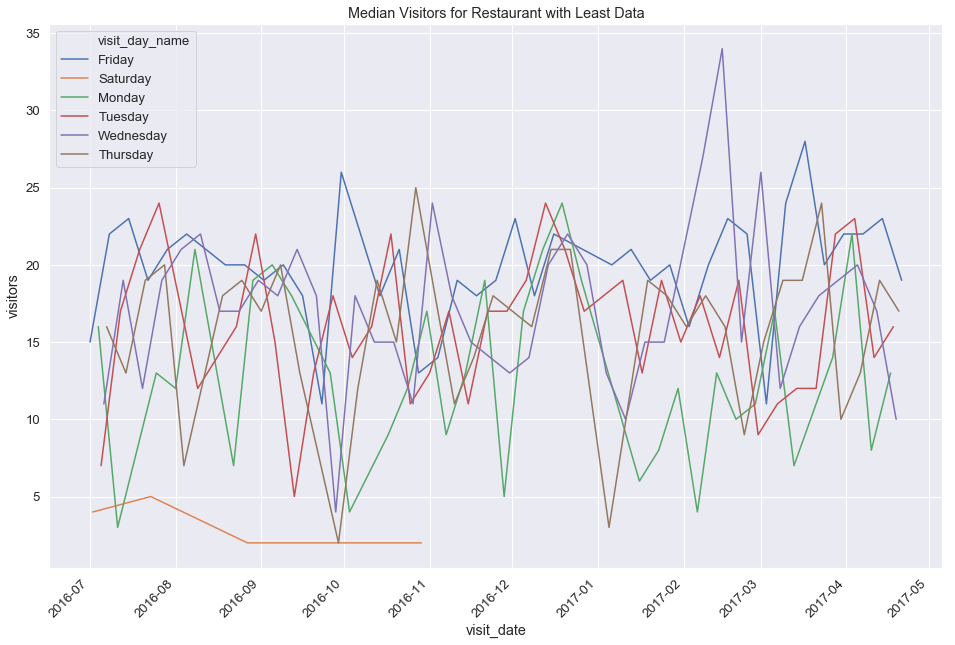

In [8]:
least_df = vfp.plot_median_visitors_daily(df.loc[df['air_store_id'] == 'air_c66dbd2c37832d00', :], stores_subset=None,
                               title='Median Visitors for Restaurant with Least Data')

In [9]:
least_df.groupby(by='visit_day_name').median()

visitors  visit_dow
visit_day_name                     
Friday              20.0        4.0
Monday              13.0        0.0
Saturday             3.0        5.0
Thursday            17.0        3.0
Tuesday             16.5        1.0
Wednesday           18.0        2.0

There seems to be a difference in median visitors by day name. This store has no data for Sundays and only a few months of data for Saturday. It seems they were open on Saturdays from July 2016 to October 2016, then stopped being open on Saturdays beginning November 2016.

# Data preparation
From the previous notebook, we found that there can be gaps in the recorded number of visitors to a store. The most likely reason is that the store isn't open every day of the week. This will be a problem for the seasonal time series models that I will try to fit later because the models assume a seasonal ordering in the data. If the data are like those for the restaurant with the least data available (air_c66dbd2c37832d00) above, the presence of a few months of Saturday in the beginning of the dataset changes the seasonal ordering beginning November 2016. In this section, I devise a way to prepare seasonal ordered data without gaps for every store in the dataset using the chi-squared test.

In [10]:
# gaps in visit records
least_df = df.loc[df['air_store_id']==vfd.get_least_data_store_id(), ['visit_date', 'visitors']]
least_df.head(10)

visit_date  visitors
194481 2016-07-01        15
194482 2016-07-02         4
194483 2016-07-04        16
194484 2016-07-05         7
194485 2016-07-06        11
194486 2016-07-07        16
194487 2016-07-08        22
194488 2016-07-11         3
194489 2016-07-12        17
194490 2016-07-13        19

In [11]:
least_df['visit_date'].max()

Timestamp('2017-04-21 00:00:00')

In [12]:
least_df['visit_date'].min()

Timestamp('2016-07-01 00:00:00')

In [13]:
least_df.shape

(198, 2)

In [14]:
# list of dates without gaps
pd.date_range(start=least_df['visit_date'].min(), end=least_df['visit_date'].max())

DatetimeIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
               '2016-07-09', '2016-07-10',
               ...
               '2017-04-12', '2017-04-13', '2017-04-14', '2017-04-15',
               '2017-04-16', '2017-04-17', '2017-04-18', '2017-04-19',
               '2017-04-20', '2017-04-21'],
              dtype='datetime64[ns]', length=295, freq='D')

In [15]:
gapless_df = (pd.DataFrame(index=pd.date_range(start=least_df['visit_date'].min(), end=least_df['visit_date'].max()))
                  .merge(least_df, how='left', left_index=True, right_on='visit_date'))
gapless_df.head(10)

visit_date  visitors
194481 2016-07-01      15.0
194482 2016-07-02       4.0
194678 2016-07-03       NaN
194483 2016-07-04      16.0
194484 2016-07-05       7.0
194485 2016-07-06      11.0
194486 2016-07-07      16.0
194487 2016-07-08      22.0
194678 2016-07-09       NaN
194678 2016-07-10       NaN

In [16]:
gapless_df.tail(10)

visit_date  visitors
194671 2017-04-12      17.0
194672 2017-04-13      19.0
194673 2017-04-14      23.0
194678 2017-04-15       NaN
194678 2017-04-16       NaN
194674 2017-04-17      13.0
194675 2017-04-18      16.0
194676 2017-04-19      10.0
194677 2017-04-20      17.0
194678 2017-04-21      19.0

In [17]:
assert (gapless_df.loc[gapless_df['visit_date'].isin(least_df['visit_date']), 'visitors'].values ==
        least_df['visitors'].values).all()
if least_df.shape[0] < gapless_df.shape[0]:
    assert gapless_df.loc[~gapless_df['visit_date'].isin(least_df['visit_date']), :].shape[0] > 0
    assert (np.isnan(gapless_df.loc[~gapless_df['visit_date'].isin(least_df['visit_date']), 'visitors'].values)).all()

In [18]:
least_df['visit_day_name'] = least_df['visit_date'].apply(lambda x: x.day_name())

## Remove days with few records
We won't be able to forecast days with few records and including them in the training data will violate the assumptions of the seasonal models. I decide to drop these days and only forecast for the days which we do have enough data. This also aligns with the business need of forecasting for the days on which the business is open.

In [19]:
# remove Saturday because it has very few datapoints
# impute other missing values and only forecast for Monday-Friday
least_df.groupby(by='visit_day_name').size()

visit_day_name
Friday       40
Monday       35
Saturday      4
Thursday     38
Tuesday      40
Wednesday    41
dtype: int64

## Chi-square test
We would expect each day to have the same number of records, but there may be holidays or other unforseen events which cause the business to close. If the number of records for all the days are "similar enough" as determined by a chi-square test against a uniform distribution, I will assume these days are representative of the business's normal operating schedule.

In [20]:
# chi-square goodness of fit test for uniform distribution
# not significant at alpha=0.05
chisquare(least_df.loc[~least_df['visit_day_name'].isin(['Saturday', 'Sunday'])].groupby(by='visit_day_name').size())

Power_divergenceResult(statistic=0.5876288659793815, pvalue=0.9644284306937106)

In [21]:
gapless_df['visit_day_name'] = gapless_df['visit_date'].apply(lambda x: x.day_name())
schedule_df = gapless_df.loc[~gapless_df['visit_day_name'].isin(['Saturday', 'Sunday']), :]

In [22]:
# chi-square goodness of fit test for uniform distribution
# not significant at alpha=0.05
chisquare(schedule_df.groupby(by='visit_day_name').size())

Power_divergenceResult(statistic=0.01895734597156398, pvalue=0.9999553602439601)

In [23]:
schedule_df.head(10)

visit_date  visitors visit_day_name
194481 2016-07-01      15.0         Friday
194483 2016-07-04      16.0         Monday
194484 2016-07-05       7.0        Tuesday
194485 2016-07-06      11.0      Wednesday
194486 2016-07-07      16.0       Thursday
194487 2016-07-08      22.0         Friday
194488 2016-07-11       3.0         Monday
194489 2016-07-12      17.0        Tuesday
194490 2016-07-13      19.0      Wednesday
194491 2016-07-14      13.0       Thursday

In [24]:
schedule_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 194481 to 194678
Data columns (total 3 columns):
visit_date        211 non-null datetime64[ns]
visitors          194 non-null float64
visit_day_name    211 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.6+ KB


## Mark and impute missing records
We still need to impute any missing records due to holidays/unforseen events in order to satisfy the seasonal ordering assumption of the seasonal time series models. There are different ways to impute these values, and I have chosen panda's interpolate method.

In [25]:
schedule_df.loc[:, 'missing'] = 0
schedule_df.loc[np.isnan(schedule_df['visitors']).values, 'missing'] = 1

In [26]:
schedule_df = schedule_df.set_index('visit_date')

In [27]:
imputed_df = schedule_df.interpolate(method='time')
imputed_df

visitors visit_day_name  missing
visit_date                                   
2016-07-01  15.000000         Friday        0
2016-07-04  16.000000         Monday        0
2016-07-05   7.000000        Tuesday        0
2016-07-06  11.000000      Wednesday        0
2016-07-07  16.000000       Thursday        0
2016-07-08  22.000000         Friday        0
2016-07-11   3.000000         Monday        0
2016-07-12  17.000000        Tuesday        0
2016-07-13  19.000000      Wednesday        0
2016-07-14  13.000000       Thursday        0
2016-07-15  23.000000         Friday        0
2016-07-18  21.500000         Monday        1
2016-07-19  21.000000        Tuesday        0
2016-07-20  12.000000      Wednesday        0
2016-07-21  19.000000       Thursday        0
2016-07-22  19.000000         Friday        0
2016-07-25  13.000000         Monday        0
2016-07-26  24.000000        Tuesday        0
2016-07-27  19.000000      Wednesday        0
2016-07-28  20.000000       Thursday        0
2016-07-29  21.000000         Friday        0
2016-08-01  12.000000         Monday        0
2016-08-02  18.000000        Tuesday        0
2016-08-03  21.000000      Wednesday        0
2016-08-04   7.000000       Thursday        0
2016-08-05  22.000000         Friday        0
2016-08-08  21.000000         Monday        0
2016-08-09  12.000000        Tuesday        0
2016-08-10  22.000000      Wednesday        0
2016-08-11  21.285714       Thursday        1
...               ...            ...      ...
2017-03-13   7.000000         Monday        0
2017-03-14  12.000000        Tuesday        0
2017-03-15  16.000000      Wednesday        0
2017-03-16  19.000000       Thursday        0
2017-03-17  28.000000         Friday        0
2017-03-20  16.000000         Monday        1
2017-03-21  12.000000        Tuesday        0
2017-03-22  18.000000      Wednesday        0
2017-03-23  24.000000       Thursday        0
2017-03-24  20.000000         Friday        0
2017-03-27  14.000000         Monday        0
2017-03-28  22.000000        Tuesday        0
2017-03-29  19.000000      Wednesday        0
2017-03-30  10.000000       Thursday        0
2017-03-31  22.000000         Friday        0
2017-04-03  22.000000         Monday        0
2017-04-04  23.000000        Tuesday        0
2017-04-05  20.000000      Wednesday        0
2017-04-06  13.000000       Thursday        0
2017-04-07  22.000000         Friday        0
2017-04-10   8.000000         Monday        0
2017-04-11  14.000000        Tuesday        0
2017-04-12  17.000000      Wednesday        0
2017-04-13  19.000000       Thursday        0
2017-04-14  23.000000         Friday        0
2017-04-17  13.000000         Monday        0
2017-04-18  16.000000        Tuesday        0
2017-04-19  10.000000      Wednesday        0
2017-04-20  17.000000       Thursday        0
2017-04-21  19.000000         Friday        0

[211 rows x 3 columns]

In [28]:
gpsd_df, gpsd_day_names = vfd.get_prepared_store_data(df, vfd.get_least_data_store_id())
assert (gpsd_df.loc[~gpsd_df['visit_day_name'].isin(['Saturday', 'Sunday'])].index == imputed_df.index).all()
for column in imputed_df.columns:
    assert (gpsd_df.loc[~gpsd_df['visit_day_name'].isin(['Saturday', 'Sunday']), column] == imputed_df[column]).all()

# Time series analysis

## Check for structural breaks
The time series models assume the same data generating process throughout the data. Data collected over long periods may not satisfy that assumption because the data collected at the beginning may differ from the data collected at the end. I will use the bottom-up segmentation algorithm provided in the [ruptures](http://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/detection/bottomup.html) Python library to detect where the data may be structurally different and only use the most recent, structurally stable data for training the models.

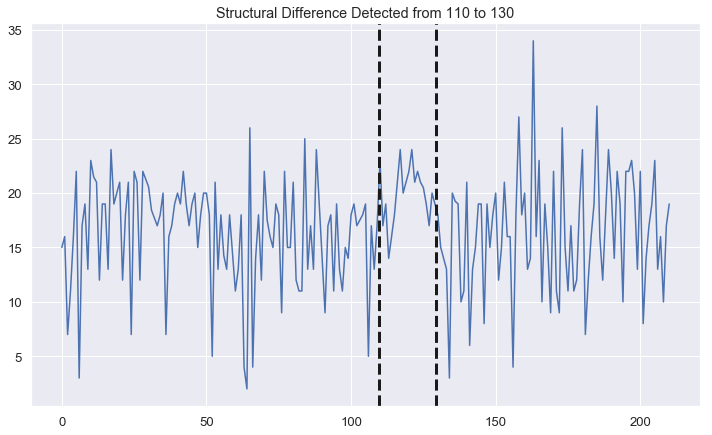

In [29]:
visitors = imputed_df['visitors']

model = 'l2'
algo = rpt.BottomUp(model=model).fit(visitors.values)
my_bkps = algo.predict(n_bkps=2)

rpt.show.display(visitors.values, [], my_bkps, figsize=(10, 6))
ax = plt.gca()
ax.set_title('Structural Difference Detected from {} to {}'.format(my_bkps[0], my_bkps[1]))
plt.show()

In [30]:
my_bkps

[110, 130, 211]

In [31]:
# structural difference during month of December (holiday season)
visitors.index[my_bkps[:-1]]

DatetimeIndex(['2016-12-02', '2016-12-30'], dtype='datetime64[ns]', name='visit_date', freq=None)

### See if it works on a random sample

In [32]:
def get_structural_breaks(store):
    all_df = vfd.get_prepared_data()
    store_df, day_names = vfd.get_prepared_store_data(all_df, store)
    visitors = store_df.loc[store_df['visit_day_name'].isin(day_names), 'visitors']
    model = 'l2'
    algo = rpt.BottomUp(model=model).fit(visitors.values)
    my_bkps = algo.predict(n_bkps=2)

    rpt.show.display(visitors.values, [], my_bkps, figsize=(16, 3))
    plt.show()

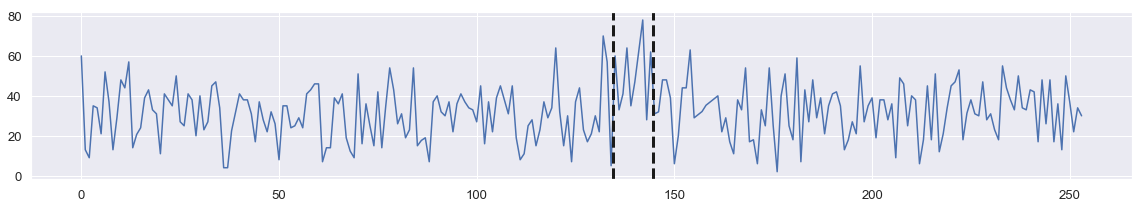

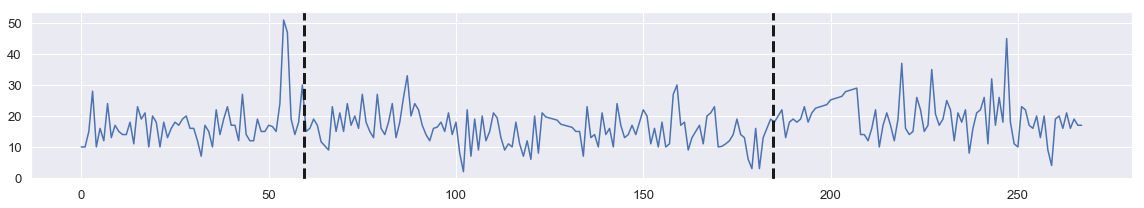

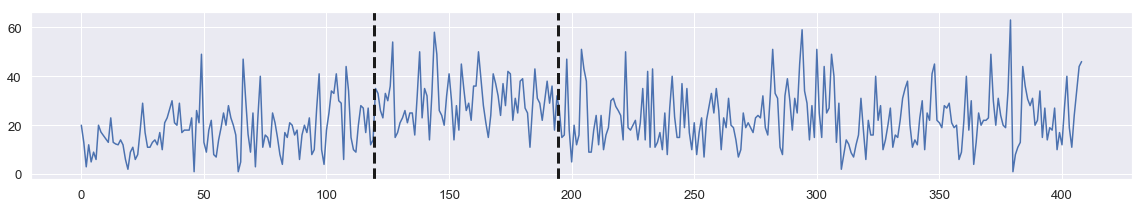

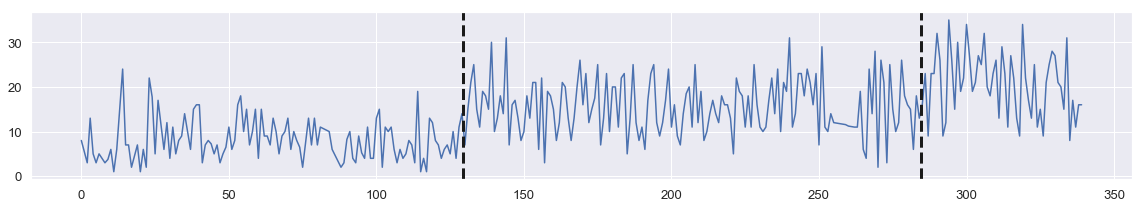

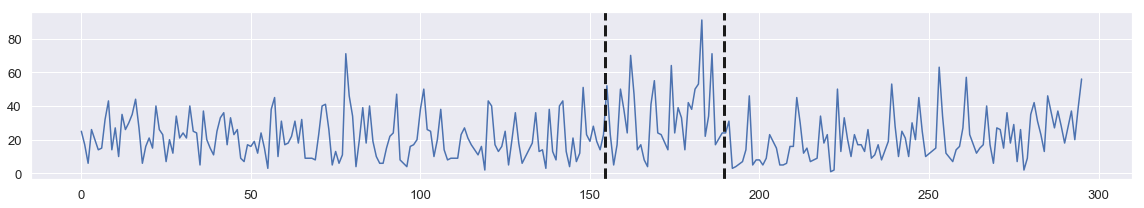

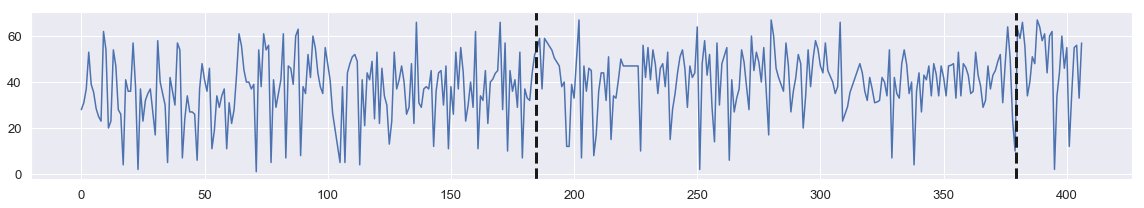

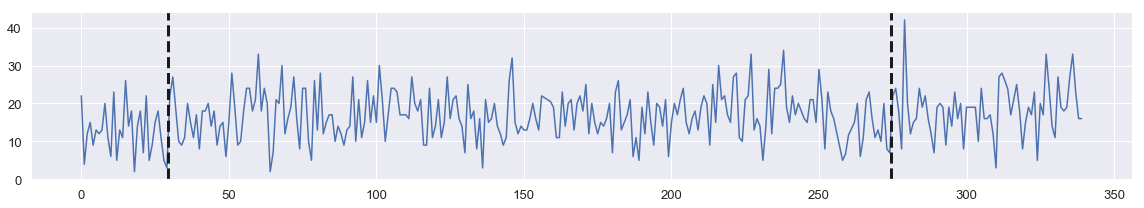

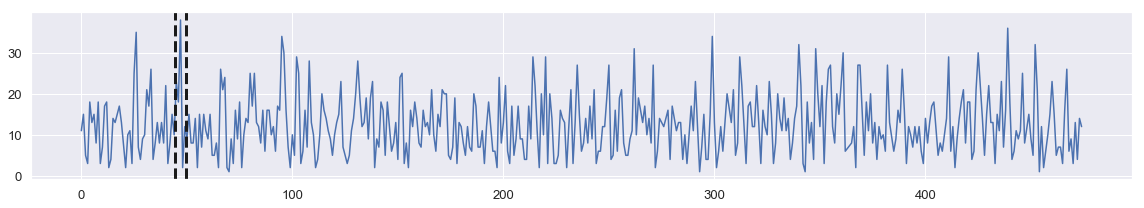

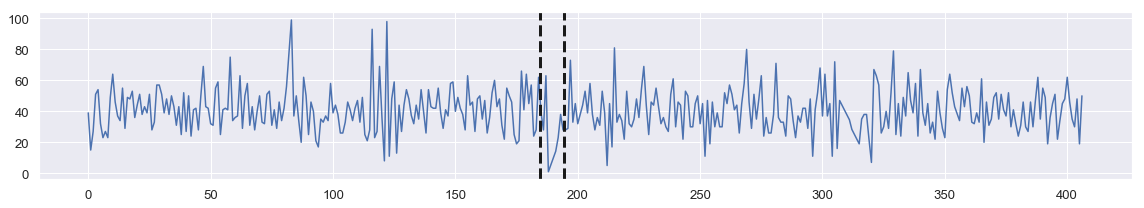

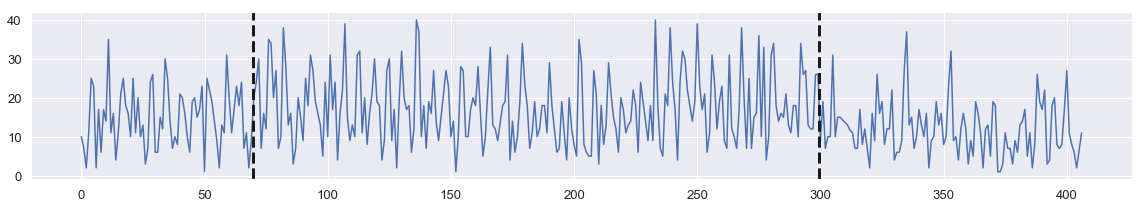

In [33]:
for store in df['air_store_id'].sample(n=10, random_state=42).values:
    get_structural_breaks(store)

The algorithm seems to work properly. However, there are two cases to keep in mind. 
1. If all the data is already structurally stable, the algorithm will still find the most structurally different part in the data. In this case, we will be left with less data than we could be using. 
2. If the structural stability of the data changes multiple times, the algorithm may not return the most recent change because it returns the most different change. In this case, we will be training on structurally unstable data, which may adversely affect the models.

## Cut off data at rupture

In [34]:
# breakpoints are in sorted order
my_bkps

[110, 130, 211]

In [35]:
# get end of rupture
rupture_end = visitors.index[my_bkps[1]]

In [36]:
# most recent data up to rupture
stable_df = imputed_df.loc[imputed_df.index > rupture_end].copy(deep=True)
stable_df.head(10)

visitors visit_day_name  missing
visit_date                                  
2017-01-02     15.00         Monday        1
2017-01-03     14.00        Tuesday        1
2017-01-04     13.00      Wednesday        0
2017-01-05      3.00       Thursday        0
2017-01-06     20.00         Friday        0
2017-01-09     19.25         Monday        1
2017-01-10     19.00        Tuesday        0
2017-01-11     10.00      Wednesday        0
2017-01-12     11.00       Thursday        0
2017-01-13     21.00         Friday        0

In [37]:
gpssd_df, gpssd_day_names = vfd.get_prepared_stable_store_data(df, vfd.get_least_data_store_id())
assert (gpssd_df.loc[gpssd_df['visit_day_name'].isin(gpssd_day_names)].index == stable_df.index).all()
for column in stable_df.columns:
    assert (gpssd_df.loc[gpssd_df['visit_day_name'].isin(gpssd_day_names), column] == stable_df[column]).all()

## Examine restaurant with the most data
Now that we are relatively confident that the data is structurally stable, we can continue with more in-depth time series analysis.

In [38]:
most_df, most_day_names = vfd.get_prepared_stable_store_data(df, vfd.get_most_data_store_id())

In [39]:
# assumed operating schedule is every day of the week
most_day_names

['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

### Split into train, validation, and test sets

In [40]:
# forecast horizon in days
most_forecast_horizon = 14

most_train = most_df[:-(2*most_forecast_horizon)]
most_test = most_df[most_df.shape[0]-most_forecast_horizon:]
most_validation = most_df[most_train.shape[0]:most_train.shape[0]+most_forecast_horizon]

In [41]:
assert most_forecast_horizon == most_test.shape[0]
assert most_forecast_horizon == most_validation.shape[0]
assert most_train.shape[0] + most_test.shape[0] + most_validation.shape[0] == most_df.shape[0]
assert (most_train.append(most_validation.append(most_test)).index == most_df.index).all()

In [42]:
tvts_train, tvts_validation, tvts_test = vfm.train_validation_test_split(most_df, most_forecast_horizon)
assert (tvts_train['visitors'] == most_train['visitors']).all()
assert (tvts_test['visitors'] == most_test['visitors']).all()
assert (tvts_validation['visitors'] == most_validation['visitors']).all()

> Although a seasonal ARIMA model seems to have only a few parameters, remember that backforecasting requires the estimation of one or two seasons' worth of implicit parameters to initialize it. Therefore, you should have at least 4 or 5 seasons of data to fit a seasonal ARIMA model.
> 
> Source: [Robert Nau, Duke University](https://people.duke.edu/~rnau/seasarim.htm)

In [43]:
# check that there is at least 4 seasons worth of data available for training
most_train.loc[most_train['visit_day_name'].isin(most_day_names)].shape[0] > len(most_day_names) * 4

True

In [44]:
assert vfm.is_enough_data_available(most_train.loc[most_train['visit_day_name'].isin(most_day_names)], len(most_day_names))

### AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF)

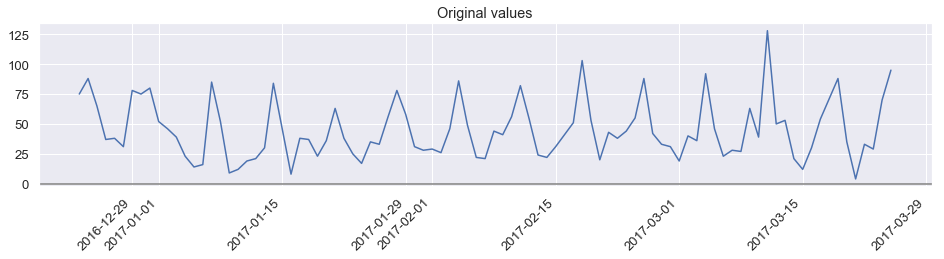

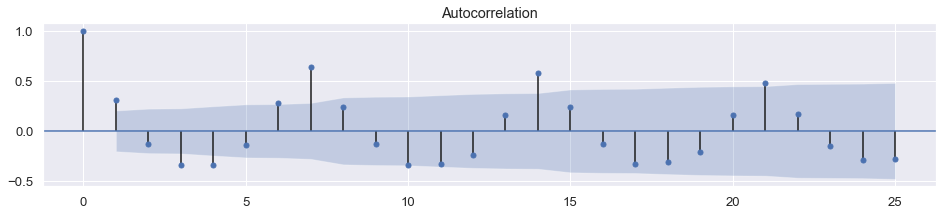

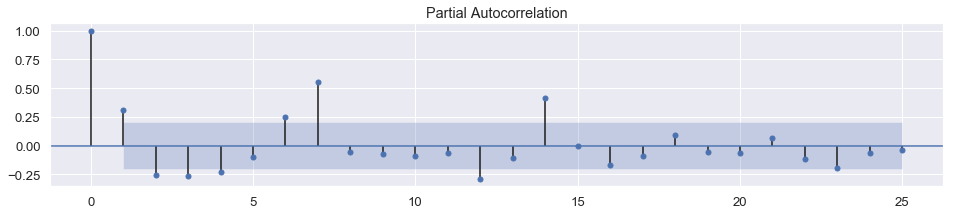

In [45]:
vfp.plot_acf_pacf(df=most_train.loc[most_train['visit_day_name'].isin(most_day_names)])

The wave-like pattern in the ACF indicates seasonality in the data. This corroborates the weekly seasonality noticed in the previous notebook.

#### AutoRegressive Integrated Moving Average (ARIMA) model
> A popular and widely used statistical method for time series forecasting is the ARIMA model.
>
> Source: [Jason Brownlee, Machine Learning Mastery](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

I will use ARIMA as a baseline model. The ARIMA model doesn't handle seasonality, so I don't expect it to perform well. I will use the [pmdarima](https://www.alkaline-ml.com/pmdarima/) Python library to search for the best fitting ARIMA model. 

In [46]:
most_arima = pm.auto_arima(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'], exogenous=None,
             start_p=0, d=None, start_q=0, max_p=7, max_d=2, max_q=7,
             seasonal=False, stationary=False,
             information_criterion='aicc',
             alpha=0.05, test='kpss',
             stepwise=True,
             error_action='ignore')
most_arima

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 0, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=False,
      transparams=True, trend=None, with_intercept=True)

In [47]:
assert (most_arima.get_params() ==
        vfm.fit_arima(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors']).get_params())

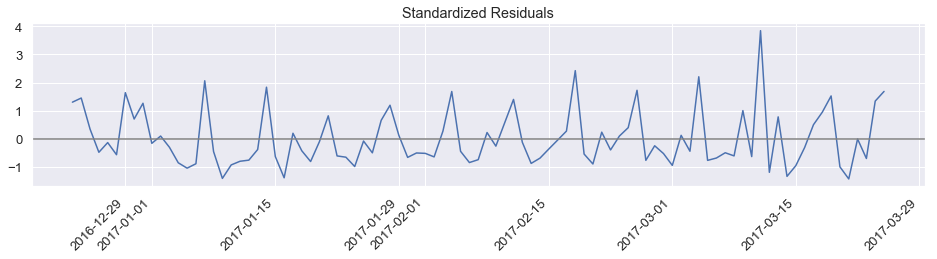

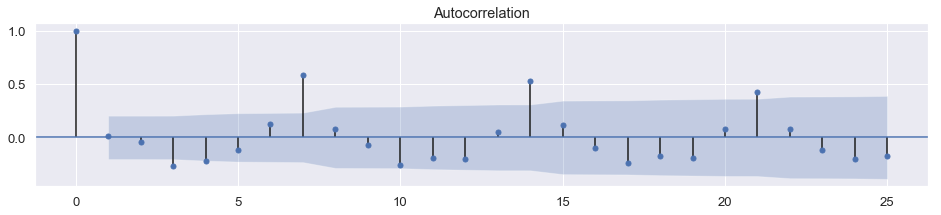

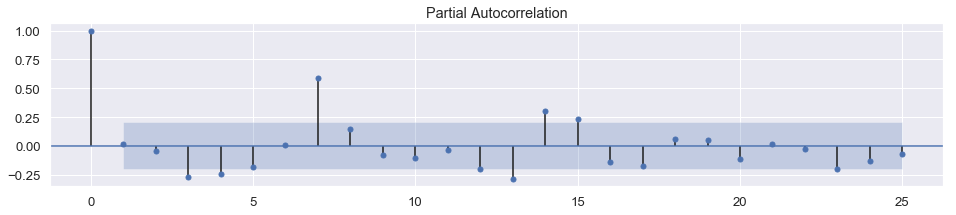

In [48]:
vfp.plot_acf_pacf(index=most_train.loc[most_train['visit_day_name'].isin(most_day_names)].index,
                  values=most_arima.resid()/np.std(most_arima.resid()),
                  title='Standardized Residuals')

The ACF still shows the wave-like pattern because ARIMA doesn't handle seasonality.

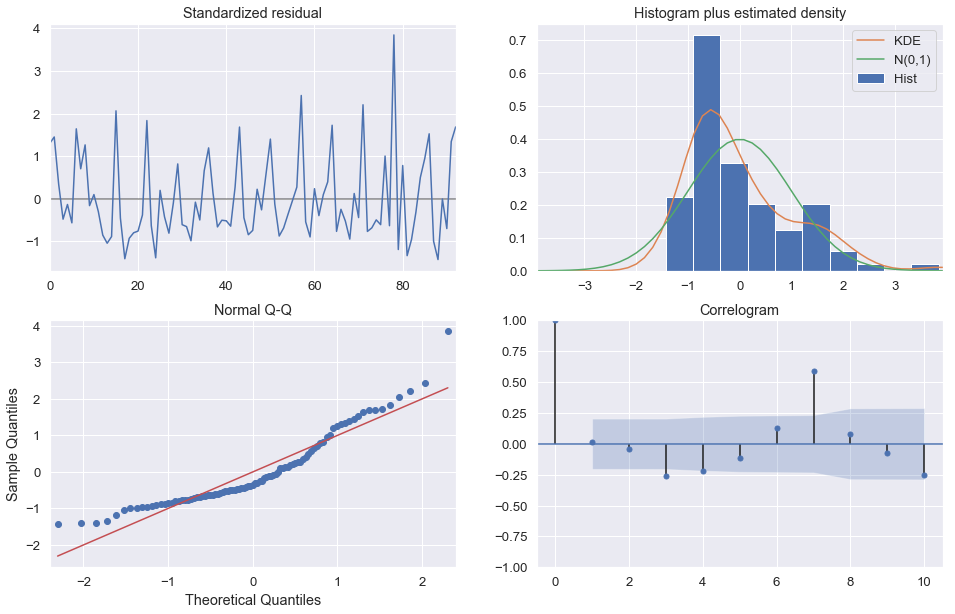

In [49]:
most_arima.plot_diagnostics()
fig = plt.gcf()
fig.set_size_inches(16, 10)

There seems to be a pattern to the residuals. From the ACF/PACF and residuals plots, I conclude this model wasn't able to capture all the patterns present in the data.

##### Use the statsmodels implementation for forecasting
I couldn't find the confidence intervals for forecasts in pmdarima's implementation of ARIMA, so I decided to fit a statsmodels ARIMA model with the order found by pmdarima.

In [50]:
most_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                     ARMA(0, 1)   Log Likelihood                -423.244
Method:                       css-mle   S.D. of innovations             22.904
Date:                Thu, 08 Aug 2019   AIC                            852.488
Time:                        13:13:08   BIC                            860.085
Sample:                             0   HQIC                           855.555
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.1657      3.234     13.966      0.000      38.827      51.504
ma.L1.y        0.3655      0.091      4.026      0.000       0.188       0.543
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.7360           +0.0000j            2.7360            0.5000
-----------------------------------------------------------------------------
"""

In [51]:
# use algorithm from statsmodels because it has confidence intervals
most_arima_results = sm.tsa.ARIMA(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_arima.order).fit()

print(most_arima_results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   93
Model:                     ARMA(0, 1)   Log Likelihood                -423.244
Method:                       css-mle   S.D. of innovations             22.904
Date:                Thu, 08 Aug 2019   AIC                            852.488
Time:                        13:13:08   BIC                            860.085
Sample:                             0   HQIC                           855.555
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.1657      3.234     13.966      0.000      38.827      51.504
ma.L1.y        0.3655      0.091      4.026      0.000       0.188       0.543
                                    Roots           

In [52]:
assert (most_arima_results.params ==
        vfm.fit_arima_results(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
                              most_arima.order).params).all()

In [53]:
# forecast from pmdarima
most_arima.predict(most_forecast_horizon)

array([59.27628971, 45.16570912, 45.16570912, 45.16570912, 45.16570912,
       45.16570912, 45.16570912, 45.16570912, 45.16570912, 45.16570912,
       45.16570912, 45.16570912, 45.16570912, 45.16570912])

In [54]:
# forecast and 95% confidence intervals from statsmodels
most_arima_results.forecast(most_forecast_horizon, alpha=0.05)

(array([59.27628971, 45.16570912, 45.16570912, 45.16570912, 45.16570912,
        45.16570912, 45.16570912, 45.16570912, 45.16570912, 45.16570912,
        45.16570912, 45.16570912, 45.16570912, 45.16570912]),
 array([22.90372401, 24.38558645, 24.38558645, 24.38558645, 24.38558645,
        24.38558645, 24.38558645, 24.38558645, 24.38558645, 24.38558645,
        24.38558645, 24.38558645, 24.38558645, 24.38558645]),
 array([[ 14.38581553, 104.1667639 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ],
        [ -2.62916207,  92.9605803 ]]))

In [55]:
fpa_forecast, fpa_conf_int, fpa_residuals = vfm.fit_predict_arima(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_forecast_horizon,
    most_arima.order)
assert (fpa_forecast == most_arima_results.forecast(most_forecast_horizon)[0]).all()
assert (fpa_conf_int == most_arima_results.forecast(most_forecast_horizon)[2]).all()
assert (fpa_residuals == most_arima_results.resid).all()

#### Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model
SARIMAX is ARIMA, but with capability for modeling seasonality and support for exogenous variables. I will use pmdarima again to fit the best SARIMAX model to the data.

In [56]:
most_sarimax = pm.auto_arima(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'], exogenous=None,
                 start_p=0, d=None, start_q=0, max_p=7, max_d=1, max_q=7,
                 m=len(most_day_names), start_P=0, D=None, start_Q=0, max_P=2, max_D=1, max_Q=2,
                 seasonal=True, stationary=False,
                 information_criterion='aicc',
                 alpha=0.05, test='kpss',
                 stepwise=True,
                 error_action='ignore')
most_sarimax

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 7), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [57]:
assert (most_sarimax.get_params() ==
        vfm.fit_sarimax(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'],
                        sarimax_m=len(most_day_names)).get_params())

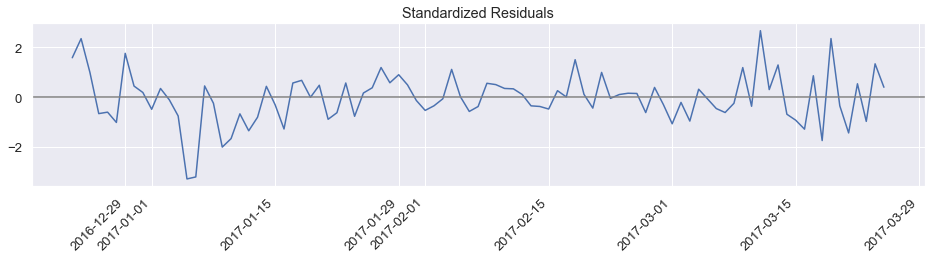

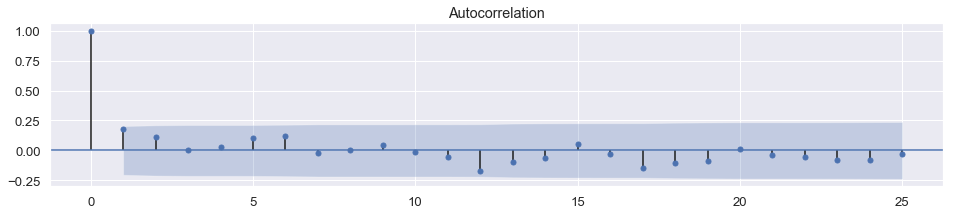

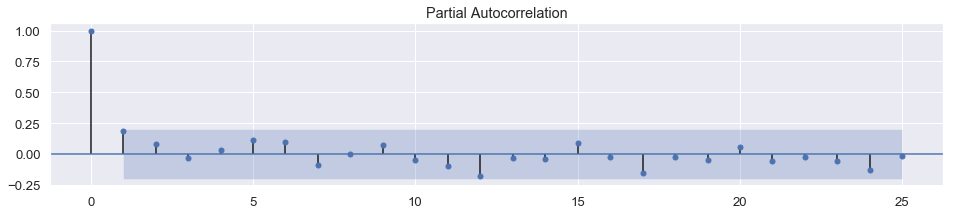

In [58]:
vfp.plot_acf_pacf(index=most_train.loc[most_train['visit_day_name'].isin(most_day_names)].index,
                  values=most_sarimax.resid()/np.std(most_sarimax.resid()),
                  title='Standardized Residuals')

None of the lags are significant.

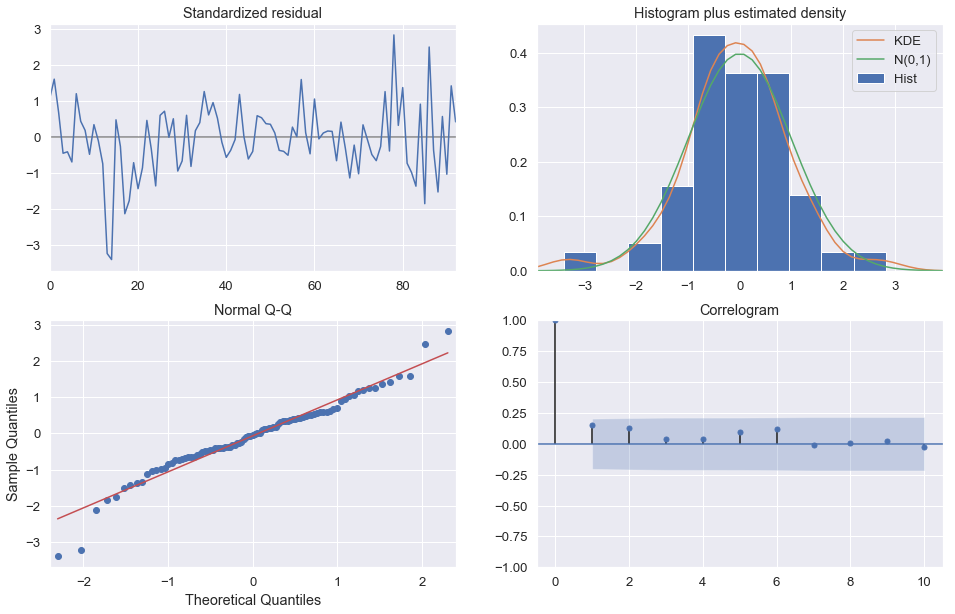

In [59]:
most_sarimax.plot_diagnostics()
fig = plt.gcf()
fig.set_size_inches(16, 10)

The residuals are approximately normally distributed. There doesn't seem to be a pattern to the residuals, but there are some outliers. Overall, I conclude this model has done well at capturing the patterns in the data.

##### Use the statsmodels implementation for forecasting

In [60]:
most_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                   93
Model:             SARIMAX(2, 0, 0, 7)   Log Likelihood                -393.400
Date:                 Thu, 08 Aug 2019   AIC                            794.801
Time:                         13:13:13   BIC                            804.931
Sample:                              0   HQIC                           798.891
                                  - 93                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.4500      4.243      1.991      0.046       0.133      16.767
ar.S.L7        0.4510      0.089      5.069      0.000       0.277       0.625
ar.S.L14       0.3739      0.113      3.299      0.001       0.152       0.596
sigma2       255.8559     28.584      8.951      0.000     199.832     311.880
===================================================================================
Ljung-Box (Q):                       21.03   Jarque-Bera (JB):                13.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.35
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
most_sarimax_results = sm.tsa.statespace.SARIMAX(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    order=most_sarimax.order,
    trend='c',
    seasonal_order=most_sarimax.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

print(most_sarimax_results.summary())

                            Statespace Model Results                           
Dep. Variable:                       y   No. Observations:                   93
Model:             SARIMAX(2, 0, 0, 7)   Log Likelihood                -328.688
Date:                 Thu, 08 Aug 2019   AIC                            665.375
Time:                         13:13:13   BIC                            674.853
Sample:                              0   HQIC                           669.172
                                  - 93                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9385      4.353      1.364      0.173      -2.594      14.471
ar.S.L7        0.5044      0.104      4.871      0.000       0.301       0.707
ar.S.L14       0.3530      0.125      2.827 

The model coefficients are different. Interestingly, the statsmodels implementation has a lower AIC even though both model have the same order and seasonal order.

In [62]:
assert (most_sarimax_results.params ==
        vfm.fit_sarimax_results(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
                                most_sarimax.order,
                                most_sarimax.seasonal_order).params).all()

In [63]:
# forecast from pmdarima
most_sarimax.predict(most_forecast_horizon)

array([66.83270264, 44.05038785, 18.10523068, 27.81995548, 32.74542787,
       60.2098488 , 77.84095296, 71.49269824, 41.40272661, 18.11125323,
       33.33479775, 34.06081641, 61.7761374 , 79.07465069])

In [64]:
# can get forecasts from results object, but not the confidence intervals
most_sarimax_results.forecast(most_forecast_horizon)

array([67.97378543, 42.30171394, 15.36953987, 26.81875306, 31.15585028,
       60.30739832, 78.91795025, 71.28848005, 39.62987427, 15.10238537,
       31.11480377, 31.89014808, 61.06730576, 79.27950729])

The forceasted values are similar to each other, so I am comfortable using the statsmodels implementation in place of the pmdarima one to get confidence intervals.

In [65]:
# forecast object from statsmodels with forecast values as predicted_mean
most_sarimax_forecast = most_sarimax_results.get_forecast(steps=most_forecast_horizon)
most_sarimax_forecast.predicted_mean

array([67.97378543, 42.30171394, 15.36953987, 26.81875306, 31.15585028,
       60.30739832, 78.91795025, 71.28848005, 39.62987427, 15.10238537,
       31.11480377, 31.89014808, 61.06730576, 79.27950729])

In [66]:
# 95% confidence intervals from statsmodels
most_sarimax_forecast.conf_int(alpha=0.05)

array([[ 37.56914963,  98.37842122],
       [ 11.89707814,  72.70634973],
       [-15.03509593,  45.77417566],
       [ -3.58588273,  57.22338885],
       [  0.75121449,  61.56048608],
       [ 29.90276252,  90.71203411],
       [ 48.51331446, 109.32258604],
       [ 37.23555167, 105.34140842],
       [  5.57694589,  73.68280264],
       [-18.950543  ,  49.15531375],
       [ -2.93812461,  65.16773214],
       [ -2.1627803 ,  65.94307645],
       [ 27.01437738,  95.12023413],
       [ 45.22657892, 113.33243566]])

In [67]:
fps_forecast, fps_conf_int, fps_residuals = vfm.fit_predict_sarimax(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_forecast_horizon,
    most_sarimax.order,
    most_sarimax.seasonal_order)
assert (fps_forecast == most_sarimax_forecast.predicted_mean).all()
assert (fps_conf_int == most_sarimax_forecast.conf_int(alpha=0.05)).all()
assert (fps_residuals == most_sarimax_results.resid).all()

#### Bayesian Structural Time Series (BSTS) model
BSTS is another time series model which can handle seasonality. I will use the [PyDLM](https://pydlm.github.io/pydlm_user_guide.html) implementation. There is no method for automatically fitting the best BSTS model, but I can use the best fitting SARIMAX model found by pmdarima to fit a BSTS model. The BSTS model has an auto-regressive component with parameter `degree`, which should be equivalent to `p` found for SARIMAX (the first value in the order). The BSTS model also has a seasonality component with parameter `period`, which should be equivalent to `m` for SARIMAX (the last value in the seasonal order).

In [68]:
most_sarimax.order

(0, 0, 0)

In [69]:
most_sarimax.seasonal_order

(2, 0, 0, 7)

In [70]:
most_dlm_trend_const = trend(degree=0, discount=0.95, name='trend_const', w=10)
most_dlm_ar1 = autoReg(degree=most_sarimax.order[0], discount=0.95, name='ar1', w=10)
most_dlm_weekly = seasonality(period=most_sarimax.seasonal_order[3], discount=0.99, name='week', w=1e7)
most_dlm = (dlm(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values) +
            most_dlm_trend_const +
            most_dlm_ar1 +
            most_dlm_weekly)
most_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [71]:
assert vfm.fit_bsts(most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
             most_sarimax.order,
             most_sarimax.seasonal_order).getLatentState() == most_dlm.getLatentState()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


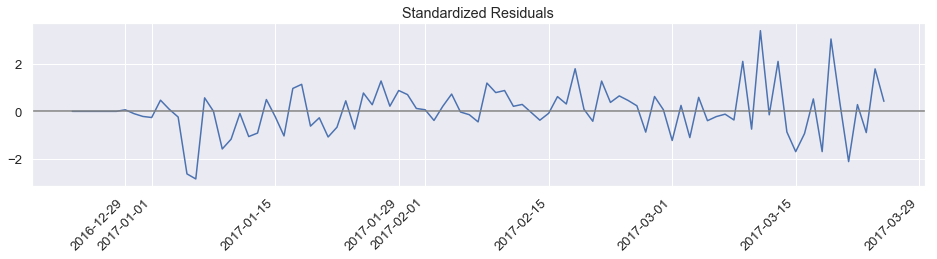

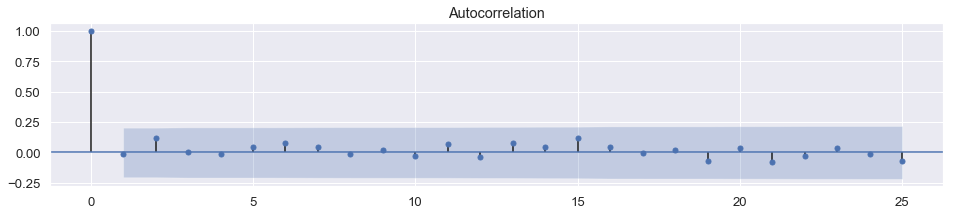

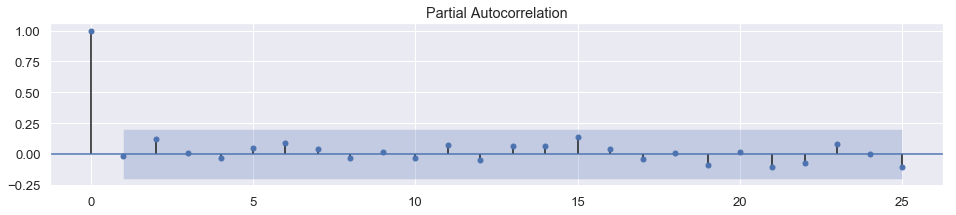

In [72]:
vfp.plot_acf_pacf(index=most_train.loc[most_train['visit_day_name'].isin(most_day_names)].index,
                  values=most_dlm.getResidual()/np.std(most_dlm.getResidual()),
                  title='Standardized Residuals')

There are no strong lags. There doesn't seem to be a pattern in the residuals, although they seem to increase in variance.

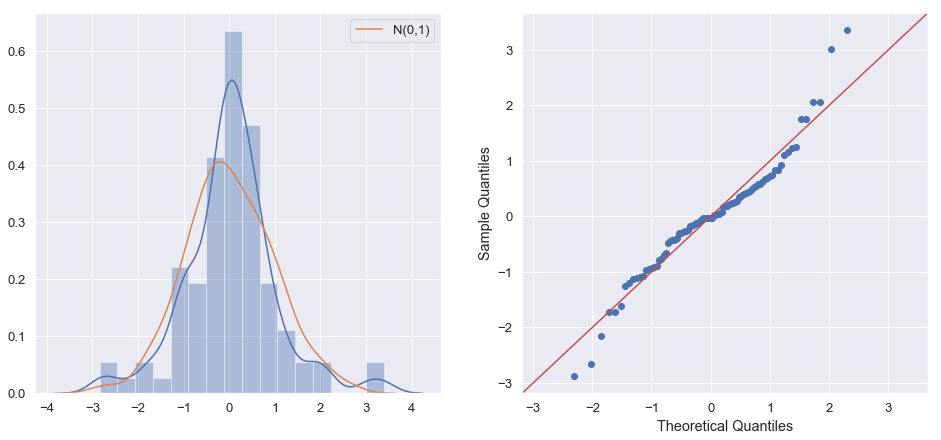

In [73]:
ax = plt.subplot2grid((1, 2), (0, 0))
sns.distplot(most_dlm.getResidual()/np.std(most_dlm.getResidual()), ax=ax)
sns.distplot(np.random.standard_normal(1000),
    kde=True, hist=False, norm_hist=True, label='N(0,1)')

ax = plt.subplot2grid((1, 2), (0, 1))
sm.qqplot(np.array(most_dlm.getResidual()), fit=True, line='45', ax=ax)
fig = plt.gcf()
fig.set_size_inches(16, 7)
plt.show()

The distribution of residuals seems to have fatter tails than a normal distribution. There are more outliers than expected. Overall, this model has potential to fit the data well.

In [74]:
most_bsts_forecast, most_bsts_variance = most_dlm.predictN(date=most_dlm.n-1, N=14)

In [75]:
most_bsts_forecast

[55.946907204834,
 30.854061755950774,
 26.896168111604084,
 30.533620110495967,
 39.25076180903399,
 51.344942687598525,
 90.57441879874835,
 55.946907204834,
 30.854061755950774,
 26.896168111604084,
 30.533620110495967,
 39.25076180903399,
 51.344942687598525,
 90.57441879874835]

In [76]:
most_bsts_std_dev = pd.Series(most_bsts_variance).apply(math.sqrt)
most_bsts_95_lower = (most_bsts_forecast - 2*most_bsts_std_dev)
most_bsts_95_upper = (most_bsts_forecast + 2*most_bsts_std_dev)

In [77]:
np.array([most_bsts_95_lower, most_bsts_95_upper]).transpose()

array([[ 2.89930636e+01,  8.29007508e+01],
       [ 3.92839301e+00,  5.77797305e+01],
       [-1.04264874e-03,  5.37933789e+01],
       [ 3.66619554e+00,  5.74010447e+01],
       [ 1.24227814e+01,  6.60787423e+01],
       [ 2.45776598e+01,  7.81122256e+01],
       [ 6.38446708e+01,  1.17304167e+02],
       [ 2.89930636e+01,  8.29007508e+01],
       [ 3.92839301e+00,  5.77797305e+01],
       [-1.04264874e-03,  5.37933789e+01],
       [ 3.66619554e+00,  5.74010447e+01],
       [ 1.24227814e+01,  6.60787423e+01],
       [ 2.45776598e+01,  7.81122256e+01],
       [ 6.38446708e+01,  1.17304167e+02]])

In [78]:
fpb_forecast, fpb_conf_int, fpb_residuals = vfm.fit_predict_bsts(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_forecast_horizon,
    most_sarimax.order,
    most_sarimax.seasonal_order)
assert (fpb_forecast == most_bsts_forecast).all()
assert (fpb_conf_int[:,0] == most_bsts_95_lower).all()
assert (fpb_conf_int[:,1] == most_bsts_95_upper).all()
assert (fpb_residuals == most_dlm.getResidual()).all()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


### Search for best window size
The amount of previous data used to train the model is a hyper parameter. I tune it by training the model on all possible window sizes in the training set and select the window size which gives the lowest root mean squared log error (RMSLE) on the validation set. I use the RMSLE instead of the RMSE for the following reasons:

> 1. The RMSE explodes in magnitude as soon as it encounters an outlier. In contrast, even on the introduction of the outlier, the RMSLE error is not affected much.
>
> 2. RMSLE metric only considers the relative error between and the Predicted and the actual value and the scale of the error is not significant. On the other hand, RMSE value Increases in magnitude if the scale of error increases.
>
> 3. RMSLE incurs a larger penalty for the underestimation of the Actual variable than the Overestimation. This is especially useful for business cases where the underestimation of the target variable is not acceptable but overestimation can be tolerated.
>
> Source: [Sharoon Saxena](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

Point 3 is especially important for restaurants, since underestimating the number of visitors has worse consequences than overestimating the number of visitors. Underestimating could lead to not having enough food and staff on hand, which would negatively impact customer satisfaction and sales more than overestimating.

Note: I choose the minimum squared log error (SLE) instead of the RMSLE because SLE requires fewer calculations and both select the same window size.

#### ARIMA

In [79]:
def get_arima_window_size(train, validation, missing, order, season_length):
    best_window_size = len(train)
    best_sle = np.inf
    errors = []
    for i in range(0, len(train) - (4*season_length)):
        results = vfm.fit_arima_results(train[i:], order)
        sle = vfm.get_sle(results.forecast(len(validation))[0], validation, missing)
        errors.append(sle)
        if sle <= best_sle:
            best_sle = sle
            best_window_size = len(train) - i
    return best_window_size, pd.Series(errors[::-1], index=range(4*season_length, len(train)))

In [80]:
most_arima_window_size, most_arima_errors = get_arima_window_size(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_arima.order,
    len(most_day_names))

In [81]:
most_arima_window_size

81

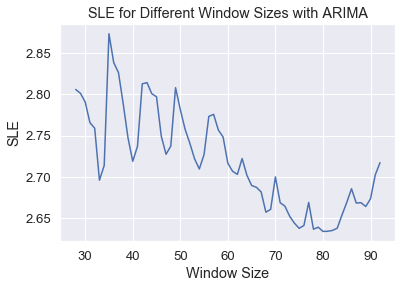

In [82]:
plt.plot(most_arima_errors)
ax = plt.gca()
ax.set_title('SLE for Different Window Sizes with ARIMA')
ax.set_xlabel('Window Size')
ax.set_ylabel('SLE')
plt.show()

In [83]:
gaws_window_size, gaws_errors = vfm.get_arima_window_size(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_arima.order,
    len(most_day_names))
assert gaws_window_size == most_arima_window_size
assert (gaws_errors == most_arima_errors).all()

In [84]:
gws_window_size, gws_errors = vfm.get_window_size(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    'arima',
    len(most_day_names),
    arima_order=most_arima.order)
assert gaws_window_size == gws_window_size
assert (gaws_errors == gws_errors).all()

#### SARIMAX

In [85]:
def get_sarimax_window_size(train, validation, missing, order, seasonal_order):
    warnings.filterwarnings('ignore')
    
    best_window_size = len(train)
    best_sle = np.inf
    errors = []
    for i in range(0, len(train) - (4*seasonal_order[3])):
        results = vfm.fit_sarimax_results(train[i:], order, seasonal_order)
        sle = vfm.get_sle(results.forecast(len(validation)), validation, missing)
        errors.append(sle)
        if sle < best_sle:
            best_sle = sle
            best_window_size = len(train) - i
            
    warnings.resetwarnings()
    return best_window_size, pd.Series(errors[::-1], index=range(4*seasonal_order[3], len(train)))

In [86]:
most_sarimax_window_size, most_sarimax_errors = get_sarimax_window_size(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_sarimax.order,
    most_sarimax.seasonal_order)

In [87]:
most_sarimax_window_size

31

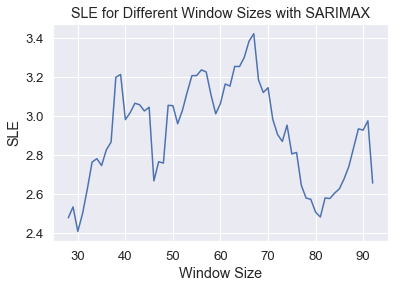

In [88]:
plt.plot(most_sarimax_errors)
ax = plt.gca()
ax.set_title('SLE for Different Window Sizes with SARIMAX')
ax.set_xlabel('Window Size')
ax.set_ylabel('SLE')
plt.show()

In [89]:
gsws_window_size, gsws_errors = vfm.get_sarimax_window_size(   
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_sarimax.order,
    most_sarimax.seasonal_order)
assert gsws_window_size == most_sarimax_window_size
assert (gsws_errors == most_sarimax_errors).all()

In [90]:
gws_window_size, gws_errors = vfm.get_window_size(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    'sarimax',
    len(most_day_names),
    sarimax_order=most_sarimax.order,
    sarimax_seasonal_order=most_sarimax.seasonal_order)
assert gsws_window_size == gws_window_size
assert (gsws_errors == gws_errors).all()

#### BSTS

In [91]:
most_bsts_window_size, most_bsts_errors = vfm.get_window_size(
    most_train.loc[most_train['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_validation.loc[most_validation['visit_day_name'].isin(most_day_names), 'missing'].values,
    'bsts',
    len(most_day_names),
    bsts_order=most_sarimax.order,
    bsts_seasonal_order=most_sarimax.seasonal_order)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

In [92]:
most_bsts_window_size

86

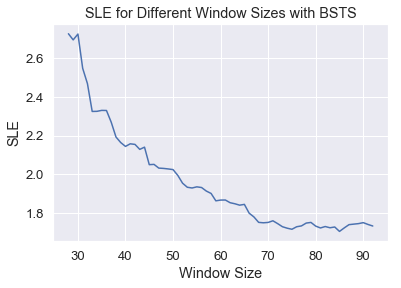

In [93]:
plt.plot(most_bsts_errors)
ax = plt.gca()
ax.set_title('SLE for Different Window Sizes with BSTS')
ax.set_xlabel('Window Size')
ax.set_ylabel('SLE')
plt.show()

SARIMAX acheives its lowest SLE with the least amount of data. ARIMA and BSTS acheive a lower SLE on the validation set as the window size increases, up to a certain point. ARIMA stops seeing benefit at a window size of 81, while BSTS seems like it could still benefit from a larger window size. Unfortunately, there is no more data available for it to train on.

### Rolling window analysis
Now that all hyperparameters for the models are known, it is time to select the best one for making a forecast. I perform rolling window analysis and select the model with the lowest SLE across all the data.

#### ARIMA

In [94]:
def arima_window_analysis(index, values, missing, order, window_size=28, forecast_horizon=1):
    if len(index) != len(values):
        raise ValueError('`index` and `values` must be the same length')
        
    visit_dates, outcomes, errors, residuals, forecasts, previews, models = ([] for i in range(7))
    for visit_date, i in zip(index[window_size:], range(0, len(index) - window_size - forecast_horizon + 1)):
        window = values[i:i+window_size]
        actual = values[i+window_size: i+window_size+forecast_horizon]
        missing_mask = missing[i+window_size:i+window_size+forecast_horizon]
        predictions, _, resids = vfm.fit_predict_arima(window,
                                               forecast_horizon,
                                               arima_order=order)
        visit_dates.append(visit_date)
        outcomes.append(values[i+window_size])
        previews.append(predictions[0])
        forecasts.append(predictions)
        errors.append(vfm.get_sle(predictions, actual, missing_mask))
        residuals.append(resids)
        models.append('{}_{}_{}'.format('arima', window_size, forecast_horizon))

    results = pd.DataFrame(index=visit_dates)
    results['outcome'] = outcomes
    results['forecast_error'] = errors
    results['fitted_residuals'] = residuals
    results['forecast'] = forecasts
    results['preview'] = previews
    results['model'] = models
        
    return results

In [95]:
# combine train and validation data for more data to perform window analysis on
most_train_full = most_train.append(most_validation)
assert most_train_full.shape[0] == most_train.shape[0] + most_validation.shape[0]
assert most_train.index[0] == most_train_full.index[0]
assert most_validation.index[-1] == most_train_full.index[-1]

In [96]:
most_arima_analysis = arima_window_analysis(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_arima.order,
    window_size=most_arima_window_size,
    forecast_horizon=vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
        most_forecast_horizon,
        most_day_names)
)

In [97]:
most_arima_analysis

outcome  forecast_error  \
2017-03-14       21        9.227740   
2017-03-15       12        8.476892   
2017-03-16       30        7.230082   
2017-03-17       54        7.216665   
2017-03-18       71        7.445621   
2017-03-19       88        7.299563   
2017-03-20       35        7.308348   
2017-03-21        4        6.862054   
2017-03-22       33        2.673709   
2017-03-23       29        2.693746   
2017-03-24       70        3.075629   
2017-03-25       95        2.501772   
2017-03-26       33        2.634198   

                                             fitted_residuals  \
2017-03-14  [29.947280903969265, 34.02300181943929, 8.8203...   
2017-03-15  [43.71954331401725, 8.627933048627854, -9.8643...   
2017-03-16  [21.689773686729353, -12.269901248815064, -1.6...   
2017-03-17  [-5.830597406549373, -3.2017115987793634, -10....   
2017-03-18  [-5.1391895479535705, -10.700901943453017, 38....   
2017-03-19  [-12.50281434574488, 38.0635707234501, 19.6780...   
2017-03-20  [33.54051613014283, 20.3872915770812, 28.74638...   
2017-03-21  [31.33310159778803, 27.249938609790505, -0.291...   
2017-03-22  [37.20090306619697, -1.7670230329053087, 3.771...   
2017-03-23  [9.751826613782093, 0.9209025946563862, -3.540...   
2017-03-24  [4.111876284037486, -4.073741209950373, -17.60...   
2017-03-25  [-3.3462271496830027, -18.40921245688417, -22....   
2017-03-26  [-20.02438451261058, -22.947091792625166, -19....   

                                                     forecast    preview  \
2017-03-14  [50.297057197031066, 45.052719096030735, 45.05...  50.297057   
2017-03-15  [35.89395975131756, 44.28045668598275, 44.2804...  35.893960   
2017-03-16  [36.35410462231315, 43.31022631327065, 43.3102...  36.354105   
2017-03-17  [41.024481119129206, 42.83059740654937, 42.830...  41.024481   
2017-03-18  [47.038988789210336, 43.13918954795357, 43.139...  47.038989   
2017-03-19  [50.8911277253914, 43.50281434574488, 43.50281...  50.891128   
2017-03-20  [56.57513421100034, 44.45948386985717, 44.4594...  56.575134   
2017-03-21  [37.13543655177969, 43.66689840221197, 43.6668...  37.135437   
2017-03-22  [32.27048602604305, 42.79909693380303, 42.7990...  32.270486   
2017-03-23  [42.5703851241091, 42.24817338621791, 42.24817...  42.570385   
2017-03-24  [37.67471856283118, 41.888123715962514, 41.888...  37.674719   
2017-03-25  [52.086048148109136, 42.346227149683, 42.34622...  52.086048   
2017-03-26  [56.96407968259095, 43.02438451261058, 43.0243...  56.964080   

                  model  
2017-03-14  arima_81_14  
2017-03-15  arima_81_14  
2017-03-16  arima_81_14  
2017-03-17  arima_81_14  
2017-03-18  arima_81_14  
2017-03-19  arima_81_14  
2017-03-20  arima_81_14  
2017-03-21  arima_81_14  
2017-03-22  arima_81_14  
2017-03-23  arima_81_14  
2017-03-24  arima_81_14  
2017-03-25  arima_81_14  
2017-03-26  arima_81_14

In [98]:
assert (vfm.rolling_window_analysis(
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
            'arima',
            window_size=most_arima_window_size,
            forecast_horizon=vfm.get_forecast_horizon(
                most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
                most_forecast_horizon,
                most_day_names),
            arima_order=most_arima.order)[['forecast_error', 'preview']].eq(
        most_arima_analysis[['forecast_error', 'preview']])).values.flatten().all()

#### SARIMAX

In [99]:
def sarimax_window_analysis(index, values, missing, order, seasonal_order, window_size=28, forecast_horizon=1):
    if len(index) != len(values):
        raise ValueError('`index` and `values` must be the same length')
        
    visit_dates, outcomes, errors, residuals, forecasts, previews, models = ([] for i in range(7))
    for visit_date, i in zip(index[window_size:], range(0, len(index) - window_size - forecast_horizon + 1)):
        window = values[i:i+window_size]
        actual = values[i+window_size: i+window_size+forecast_horizon]
        missing_mask = missing[i+window_size:i+window_size+forecast_horizon]
        predictions, _, resids = vfm.fit_predict_sarimax(window,
                                                 forecast_horizon,
                                                 sarimax_order=order,
                                                 sarimax_seasonal_order=seasonal_order)
        visit_dates.append(visit_date)
        outcomes.append(values[i+window_size])
        previews.append(predictions[0])
        forecasts.append(predictions)
        errors.append(vfm.get_sle(predictions, actual, missing_mask))
        residuals.append(resids)
        models.append('{}_{}_{}'.format('sarimax', window_size, forecast_horizon))

    results = pd.DataFrame(index=visit_dates)
    results['outcome'] = outcomes
    results['forecast_error'] = errors
    results['fitted_residuals'] = residuals
    results['forecast'] = forecasts
    results['preview'] = previews
    results['model'] = models
        
    return results

In [100]:
most_sarimax_analysis = sarimax_window_analysis(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_sarimax.order,
    most_sarimax.seasonal_order,
    window_size=most_sarimax_window_size,
    forecast_horizon=vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
        most_forecast_horizon,
        most_day_names)
)

In [101]:
most_sarimax_analysis

outcome  forecast_error  \
2017-01-23       25        3.320812   
2017-01-24       17        1.619814   
2017-01-25       35        1.853361   
2017-01-26       33        1.966099   
2017-01-27       56        1.413521   
2017-01-28       78        1.003041   
2017-01-29       58        0.763661   
2017-01-30       31        0.707830   
2017-01-31       28        0.990028   
2017-02-01       29        1.148320   
2017-02-02       26        1.079131   
2017-02-03       46        1.017624   
2017-02-04       86        1.025617   
2017-02-05       49        0.930299   
2017-02-06       22        0.963044   
2017-02-07       21        0.793941   
2017-02-08       44        0.618457   
2017-02-09       41        0.773090   
2017-02-10       56        0.710453   
2017-02-11       82        0.751126   
2017-02-12       54        0.737511   
2017-02-13       24        0.786607   
2017-02-14       22        0.580246   
2017-02-15       31        0.703435   
2017-02-16       41        1.118618   
2017-02-17       51        1.281321   
2017-02-18      103        1.463908   
2017-02-19       53        1.662029   
2017-02-20       20        1.703180   
2017-02-21       43        1.780773   
...             ...             ...   
2017-02-25       88        1.503739   
2017-02-26       42        1.437040   
2017-02-27       33        1.215893   
2017-02-28       31        1.424363   
2017-03-01       19        1.704651   
2017-03-02       40        1.668881   
2017-03-03       36        1.832361   
2017-03-04       92        1.677480   
2017-03-05       46        1.794074   
2017-03-06       23        2.106666   
2017-03-07       28        2.174698   
2017-03-08       27        5.347011   
2017-03-09       63        5.291588   
2017-03-10       39        5.763040   
2017-03-11      128        5.904773   
2017-03-12       50        6.103553   
2017-03-13       53        6.141016   
2017-03-14       21        5.680602   
2017-03-15       12        5.118331   
2017-03-16       30        6.988458   
2017-03-17       54        7.434495   
2017-03-18       71        6.659959   
2017-03-19       88        6.537035   
2017-03-20       35        5.801180   
2017-03-21        4        5.940893   
2017-03-22       33        8.844764   
2017-03-23       29        9.338533   
2017-03-24       70        4.221808   
2017-03-25       95        3.050669   
2017-03-26       33        2.408006   

                                             fitted_residuals  \
2017-01-23  [75.0, 81.58412677338873, 58.58412677338874, 3...   
2017-01-24  [88.0, 58.710007630965436, 30.710007630965436,...   
2017-01-25  [65.0, 30.084469413797116, 31.084469413797116,...   
2017-01-26  [37.0, 30.028078060904598, 23.028078060904598,...   
2017-01-27  [38.0, 20.568999166882715, 67.56899916688272, ...   
2017-01-28  [31.0, 64.62224934683829, 61.62224934683829, 6...   
2017-01-29  [78.0, 62.539277427016344, 67.53927742701634, ...   
2017-01-30  [75.0, 66.57466009526077, 38.57466009526077, 3...   
2017-01-31  [80.0, 37.7892472589812, 31.7892472589812, 24....   
2017-02-01  [52.0, 30.53808976494878, 23.53808976494878, 7...   
2017-02-02  [46.0, 24.209965745785144, 8.209965745785144, ...   
2017-02-03  [39.0, 4.337875720494658, -4.662124279505342, ...   
2017-02-04  [23.0, -4.678805269558666, -2.6788052695586657...   
2017-02-05  [14.0, 3.032397142985655, 72.03239714298566, 3...   
2017-02-06  [16.0, 71.35490293066107, 38.35490293066107, -...   
2017-02-07  [85.0, 40.573414044016005, -2.4265859559839917...   
2017-02-08  [52.0, 3.28142236459533, 6.28142236459533, 13....   
2017-02-09  [9.0, 5.686466001419024, 12.686466001419024, 1...   
2017-02-10  [12.0, 15.355440763710645, 17.355440763710646,...   
2017-02-11  [19.0, 16.146345576974614, 25.146345576974614,...   
2017-02-12  [21.0, 23.443890462681573, 77.44389046268157, ...   
2017-02-13  [30.0, 78.43621264942234, 40.43621264942235, 2...   
2017-02-14  [84.0, 43.95515160154297, 5.95515160154297, 35...   
2017-02-15  [46.0, 6.983201768395

In [102]:
assert (vfm.rolling_window_analysis(
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
            'sarimax',
            window_size=most_sarimax_window_size,
            forecast_horizon=vfm.get_forecast_horizon(
                most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
                most_forecast_horizon,
                most_day_names),
            sarimax_order=most_sarimax.order,
            sarimax_seasonal_order=most_sarimax.seasonal_order)[['forecast_error', 'preview']].eq(
        most_sarimax_analysis[['forecast_error', 'preview']])).values.flatten().all()

#### BSTS

In [103]:
most_bsts_analysis = vfm.rolling_window_analysis(
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
            most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
            'bsts',
            window_size=most_bsts_window_size,
            forecast_horizon=vfm.get_forecast_horizon(
                most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
                most_forecast_horizon,
                most_day_names),
            bsts_order=most_sarimax.order,
            bsts_seasonal_order=most_sarimax.seasonal_order)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

In [104]:
most_bsts_analysis

observed  forecast_error  \
2017-03-19  [88, 35, 4, 33, 29, 70, 95, 33, 48, 21, 39, 36...        4.661041   
2017-03-20  [35, 4, 33, 29, 70, 95, 33, 48, 21, 39, 36, 79...        4.559121   
2017-03-21  [4, 33, 29, 70, 95, 33, 48, 21, 39, 36, 79, 67...        4.716819   
2017-03-22  [33, 29, 70, 95, 33, 48, 21, 39, 36, 79, 67, 5...        1.575691   
2017-03-23  [29, 70, 95, 33, 48, 21, 39, 36, 79, 67, 55, 2...        1.688098   
2017-03-24  [70, 95, 33, 48, 21, 39, 36, 79, 67, 55, 21, 4...        1.894768   
2017-03-25  [95, 33, 48, 21, 39, 36, 79, 67, 55, 21, 45, 4...        1.663895   
2017-03-26  [33, 48, 21, 39, 36, 79, 67, 55, 21, 45, 44, 2...        1.704274   

                                              fitted_residual  \
2017-03-19  [8.66248848296891e-06, 1.1819971206250557e-05,...   
2017-03-20  [1.0163986459588159e-05, 9.369723599661484e-06...   
2017-03-21  [7.5074900109939335e-06, 5.625752486082547e-06...   
2017-03-22  [4.273494312201365e-06, 5.194514024253749e-06,...   
2017-03-23  [4.3889941565566915e-06, 4.390833353795642e-06...   
2017-03-24  [3.580495235411263e-06, 9.781374444628455e-06,...   
2017-03-25  [9.008988016034891e-06, 1.0349823440947148e-05...   
2017-03-26  [8.66248848296891e-06, 1.0879076967285073e-05,...   

                                                     forecast    preview  \
2017-03-19  [50.48035012116637, 29.057995498068223, 28.658...  50.480350   
2017-03-20  [30.51565727915893, 29.956251950676513, 30.144...  30.515657   
2017-03-21  [30.178307529221613, 30.294251739005766, 40.13...  30.178308   
2017-03-22  [29.451775799948862, 39.316766613284, 47.14854...  29.451776   
2017-03-23  [39.49718202188237, 47.30546786085513, 90.0236...  39.497182   
2017-03-24  [47.04167194149251, 89.69408475877485, 55.1115...  47.041672   
2017-03-25  [90.47782454488335, 55.83374041878106, 30.5912...  90.477825   
2017-03-26  [56.11748384195296, 30.794661965115864, 26.616...  56.117484   

                 model  
2017-03-19  bsts_86_14  
2017-03-20  bsts_86_14  
2017-03-21  bsts_86_14  
2017-03-22  bsts_86_14  
2017-03-23  bsts_86_14  
2017-03-24  bsts_86_14  
2017-03-25  bsts_86_14  
2017-03-26  bsts_86_14

### Rolling window analysis on train and validation set

In [105]:
# use model with lowest number of results as baseline
most_analysis = (most_bsts_analysis
                     .append(most_arima_analysis[-most_sarimax_analysis.shape[0]:])
                     .append(most_sarimax_analysis[-most_sarimax_analysis.shape[0]:]))
most_analysis

fitted_residual  \
2017-03-19  [8.66248848296891e-06, 1.1819971206250557e-05,...   
2017-03-20  [1.0163986459588159e-05, 9.369723599661484e-06...   
2017-03-21  [7.5074900109939335e-06, 5.625752486082547e-06...   
2017-03-22  [4.273494312201365e-06, 5.194514024253749e-06,...   
2017-03-23  [4.3889941565566915e-06, 4.390833353795642e-06...   
2017-03-24  [3.580495235411263e-06, 9.781374444628455e-06,...   
2017-03-25  [9.008988016034891e-06, 1.0349823440947148e-05...   
2017-03-26  [8.66248848296891e-06, 1.0879076967285073e-05,...   
2017-03-14                                                NaN   
2017-03-15                                                NaN   
2017-03-16                                                NaN   
2017-03-17                                                NaN   
2017-03-18                                                NaN   
2017-03-19                                                NaN   
2017-03-20                                                NaN   
2017-03-21                                                NaN   
2017-03-22                                                NaN   
2017-03-23                                                NaN   
2017-03-24                                                NaN   
2017-03-25                                                NaN   
2017-03-26                                                NaN   
2017-01-23                                                NaN   
2017-01-24                                                NaN   
2017-01-25                                                NaN   
2017-01-26                                                NaN   
2017-01-27                                                NaN   
2017-01-28                                                NaN   
2017-01-29                                                NaN   
2017-01-30                                                NaN   
2017-01-31                                                NaN   
...                                                       ...   
2017-02-25                                                NaN   
2017-02-26                                                NaN   
2017-02-27                                                NaN   
2017-02-28                                                NaN   
2017-03-01                                                NaN   
2017-03-02                                                NaN   
2017-03-03                                                NaN   
2017-03-04                                                NaN   
2017-03-05                                                NaN   
2017-03-06                                                NaN   
2017-03-07                                                NaN   
2017-03-08                                                NaN   
2017-03-09                                                NaN   
2017-03-10                                                NaN   
2017-03-11                                                NaN   
2017-03-12                                                NaN   
2017-03-13                                                NaN   
2017-03-14                                                NaN   
2017-03-15                                                NaN   
2017-03-16                                                NaN   
2017-03-17                                                NaN   
2017-03-18                                                NaN   
2017-03-19                                                NaN   
2017-03-20                                                NaN   
2017-03-21                                                NaN   
2017-03-22                                                NaN   
2017-03-23                                                NaN   
2017-03-24                                                NaN   
2017-03-25                                                NaN   
2017-03-26                                                NaN   

               

In [106]:
def all_model_rolling_window_analysis(index, train, missing, params, **kwargs):
    results = []
    lengths = []
    for model in params:
        results.append(vfm.rolling_window_analysis(index, train, missing, model, **params[model], **kwargs))
        lengths.append(results[-1].shape[0])
    
    shortest = pd.Series(lengths).idxmin()
    for i in range(len(lengths)):
        if i != shortest:
            results[shortest] = results[shortest].append(results[i][-lengths[shortest]:])
    return results[shortest]

In [107]:
most_params = {
    'arima': {
        'window_size': most_arima_window_size,
        'arima_order': most_arima.order,
    },
    'sarimax': {
        'window_size': most_sarimax_window_size,
        'sarimax_order': most_sarimax.order,
        'sarimax_seasonal_order': most_sarimax.seasonal_order,
    },
    'bsts': {
        'window_size': most_bsts_window_size,
        'bsts_order': most_sarimax.order,
        'bsts_seasonal_order': most_sarimax.seasonal_order,
    },
}
most_analysis = all_model_rolling_window_analysis(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_params,
    forecast_horizon=vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
        most_forecast_horizon,
        most_day_names))

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

In [108]:
amrwa_analysis = vfm.all_model_rolling_window_analysis(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'missing'].values,
    most_params,
    forecast_horizon=vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)].index[-1],
        most_forecast_horizon,
        most_day_names))
assert (amrwa_analysis['model'].eq(most_analysis['model'])).values.flatten().all()
assert (amrwa_analysis.index == most_analysis.index).all()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

In [109]:
most_analysis.groupby('model').mean()['forecast_error']

model
arima_81_14      4.381127
bsts_86_14       2.807963
sarimax_31_14    5.767861
Name: forecast_error, dtype: float64

### Compare mean rolling window errors to error on test set

In [110]:
most_arima_test, _, _ = vfm.fit_predict_arima(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values[-most_arima_window_size:],
    vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)][-most_arima_window_size:].index[-1],
        most_forecast_horizon,
        most_day_names),
    arima_order=most_arima.order)
most_arima_test_sle = vfm.get_sle(
    most_arima_test, 
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'missing'])
most_arima_test_sle

4.579374878560596

In [111]:
most_sarimax_test, _, _ = vfm.fit_predict_sarimax(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values[-most_sarimax_window_size:],
    vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)][-most_sarimax_window_size:].index[-1],
        most_forecast_horizon,
        most_day_names),
    sarimax_order=most_sarimax.order,
    sarimax_seasonal_order=most_sarimax.seasonal_order)
most_sarimax_test_sle = vfm.get_sle(
    most_sarimax_test, 
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'missing'])
most_sarimax_test_sle

2.619610576332713

In [112]:
assert (vfm.evaluate_model(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values[-most_sarimax_window_size:],
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'missing'],
    'sarimax',
    **most_params['sarimax']) == most_sarimax_test_sle)

In [113]:
most_bsts_test_sle = vfm.evaluate_model(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values[-most_bsts_window_size:],
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'missing'],
    'bsts',
    **most_params['bsts'])
most_bsts_test_sle

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


1.4927932689709413

### Select best model
I select the model with the lowest sum of SLE from the rolling window analysis and on the test set as the best model to perform the forecast.

In [114]:
# bsts model with window size 86 has lowest error from rolling window analysis
# and on test set for a forecast horizon of 14 days
most_total_sle = (most_analysis.groupby('model').sum()['forecast_error'] +
                  [most_arima_test_sle, most_bsts_test_sle, most_sarimax_test_sle])
most_total_sle

model
arima_81_14      39.628394
bsts_86_14       23.956500
sarimax_31_14    48.762498
Name: forecast_error, dtype: float64

In [115]:
gbm_best_model, gbm_best_window_size, gbm_test_sle = vfm.get_best_model(
    most_analysis,
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'visitors'].values,
    most_test.loc[most_test['visit_day_name'].isin(most_day_names), 'missing'],
    most_params
)
assert gbm_best_model == most_total_sle.idxmin().split('_')[0]
assert gbm_best_window_size == most_total_sle.idxmin().split('_')[1]
assert gbm_test_sle['arima'] == most_arima_test_sle
assert gbm_test_sle['sarimax'] == most_sarimax_test_sle
assert gbm_test_sle['bsts'] == most_bsts_test_sle

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [116]:
gbm_best_model

'bsts'

### Make forecast

In [117]:
most_final_results = vfm.fit_bsts_results(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'][-most_bsts_window_size:],
    bsts_order=most_sarimax.order,
    bsts_seasonal_order=most_sarimax.seasonal_order)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [118]:
most_final_forecast, most_final_conf_int, _ = vfm.fit_predict_bsts(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'][-most_bsts_window_size:],
    vfm.get_forecast_horizon(
        most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)][-most_bsts_window_size:].index[-1],
        most_forecast_horizon,
        most_day_names),
    **most_params['bsts'])

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [119]:
most_final_results.forecast(vfm.get_forecast_horizon(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)][-most_bsts_window_size:].index[-1],
    most_forecast_horizon,
    most_day_names))

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


array([52.76708188, 31.17049293, 27.0236427 , 32.8055319 , 36.34685987,
       54.7482191 , 86.31500802, 52.76708188, 31.17049293, 27.0236427 ,
       32.8055319 , 36.34685987, 54.7482191 , 86.31500802])

In [120]:
assert ((most_final_results.forecast(vfm.get_forecast_horizon(
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names)][-most_bsts_window_size:].index[-1],
    most_forecast_horizon,
    most_day_names)) ==
        most_final_forecast).all())
assert most_final_results.fittedvalues.shape[0] == most_bsts_window_size

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [121]:
most_final_full = most_df.loc[most_df['visit_day_name'].isin(most_day_names)].reset_index()
most_final_full['fitted'] = (pd.Series([np.NaN] * (most_final_full.shape[0] - most_bsts_window_size))
                               .append(pd.Series(most_final_results.fittedvalues)).values)
assert (most_final_full['fitted'][-1:] == most_final_results.fittedvalues[-1]).all()

most_forecast_data = pd.DataFrame(pd.date_range(start=(pd.to_datetime(most_final_full['visit_date'].values[-1]) +
                                      pd.DateOffset(days=1)),
                                                end=(pd.to_datetime(most_final_full['visit_date'].values[-1]) +
                                                     pd.DateOffset(days=most_forecast_horizon))),
                                  columns=['visit_date'])
most_forecast_data['visit_day_name'] = most_forecast_data['visit_date'].apply(lambda x: x.day_name())
most_forecast_data['forecast'] = most_final_forecast
assert (most_forecast_data['forecast'] == most_final_forecast).all()

most_forecast_data = most_forecast_data.join(
    pd.DataFrame(most_final_conf_int,
                 index=most_forecast_data.index,
                 columns=['95_lower', '95_upper']))
assert (most_forecast_data['95_lower'].values == most_final_conf_int[:,0]).all()
assert (most_forecast_data['95_upper'].values == most_final_conf_int[:,1]).all()

most_forecast_data = most_forecast_data.loc[most_forecast_data['visit_day_name'].isin(most_day_names)]
assert most_forecast_data.shape[0] == vfm.get_forecast_horizon(most_final_full['visit_date'].values[-1], 
                                                               most_forecast_horizon,
                                                               most_day_names)

most_forecast_data['fitted'] = np.NaN
most_final_full = most_final_full.append(most_forecast_data, sort=False).reset_index(drop=True)
assert (most_final_full['forecast'][-1:] == most_final_forecast[-1]).all()
assert (most_final_full['95_lower'][-1:] == most_final_conf_int[-1,0]).all()
assert (most_final_full['95_upper'][-1:] == most_final_conf_int[-1,1]).all()

In [122]:
most_final_full

visit_date  visitors  missing visit_day_name     fitted   forecast  \
0   2016-12-23      75.0      0.0         Friday        NaN        NaN   
1   2016-12-24      88.0      0.0       Saturday        NaN        NaN   
2   2016-12-25      65.0      0.0         Sunday        NaN        NaN   
3   2016-12-26      37.0      0.0         Monday        NaN        NaN   
4   2016-12-27      38.0      0.0        Tuesday        NaN        NaN   
5   2016-12-28      31.0      0.0      Wednesday        NaN        NaN   
6   2016-12-29      78.0      0.0       Thursday        NaN        NaN   
7   2016-12-30      75.0      0.0         Friday        NaN        NaN   
8   2016-12-31      80.0      0.0       Saturday        NaN        NaN   
9   2017-01-01      52.0      0.0         Sunday        NaN        NaN   
10  2017-01-02      46.0      0.0         Monday        NaN        NaN   
11  2017-01-03      39.0      0.0        Tuesday        NaN        NaN   
12  2017-01-04      23.0      0.0      Wednesday        NaN        NaN   
13  2017-01-05      14.0      0.0       Thursday        NaN        NaN   
14  2017-01-06      16.0      0.0         Friday        NaN        NaN   
15  2017-01-07      85.0      0.0       Saturday        NaN        NaN   
16  2017-01-08      52.0      0.0         Sunday        NaN        NaN   
17  2017-01-09       9.0      0.0         Monday        NaN        NaN   
18  2017-01-10      12.0      0.0        Tuesday        NaN        NaN   
19  2017-01-11      19.0      0.0      Wednesday        NaN        NaN   
20  2017-01-12      21.0      0.0       Thursday        NaN        NaN   
21  2017-01-13      30.0      0.0         Friday        NaN        NaN   
22  2017-01-14      84.0      0.0       Saturday        NaN        NaN   
23  2017-01-15      46.0      0.0         Sunday        NaN        NaN   
24  2017-01-16       8.0      0.0         Monday        NaN        NaN   
25  2017-01-17      38.0      0.0        Tuesday        NaN        NaN   
26  2017-01-18      37.0      0.0      Wednesday        NaN        NaN   
27  2017-01-19      23.0      0.0       Thursday        NaN        NaN   
28  2017-01-20      36.0      0.0         Friday        NaN        NaN   
29  2017-01-21      63.0      0.0       Saturday        NaN        NaN   
..         ...       ...      ...            ...        ...        ...   
105 2017-04-07      56.0      0.0         Friday  48.296858        NaN   
106 2017-04-08      71.0      0.0       Saturday  91.270443        NaN   
107 2017-04-09      40.0      0.0         Sunday  56.044194        NaN   
108 2017-04-10      26.0      0.0         Monday  30.203045        NaN   
109 2017-04-11      23.0      0.0        Tuesday  25.541608        NaN   
110 2017-04-12      44.0      0.0      Wednesday  30.434690        NaN   
111 2017-04-13      19.0      0.0       Thursday  39.235873        NaN   
112 2017-04-14      55.0      0.0         Friday  51.734585        NaN   
113 2017-04-15      69.0      0.0       Saturday  92.659047        NaN   
114 2017-04-16      60.0      0.0         Sunday  52.991780        NaN   
115 2017-04-17      18.0      0.0         Monday  33.120887        NaN   
116 2017-04-18      30.0      0.0        Tuesday  24.676070        NaN   
117 2017-04-19      20.0      0.0      Wednesday  32.074363        NaN   
118 2017-04-20      22.0      0.0       Thursday  39.499448        NaN   
119 2017-04-21      71.0      0.0         Friday  55.205360        NaN   
120 2017-04-22      97.0      0.0       Saturday  88.929316        NaN   
121 2017-04-23       NaN      NaN         Sunday        NaN  52.767082   
122 2017-04-24       NaN      NaN         Monday        NaN  31.170493   
123 2017-04-25       NaN      NaN        Tuesday        NaN  27.023643   
124 2017-04-26       NaN      NaN      Wednesday        NaN  32.805532   
125 2017-04-27       NaN      NaN       Thursday        NaN  36.346860   
126 2017-04-28       NaN      NaN         Friday        NaN  54.748219   
127 2017

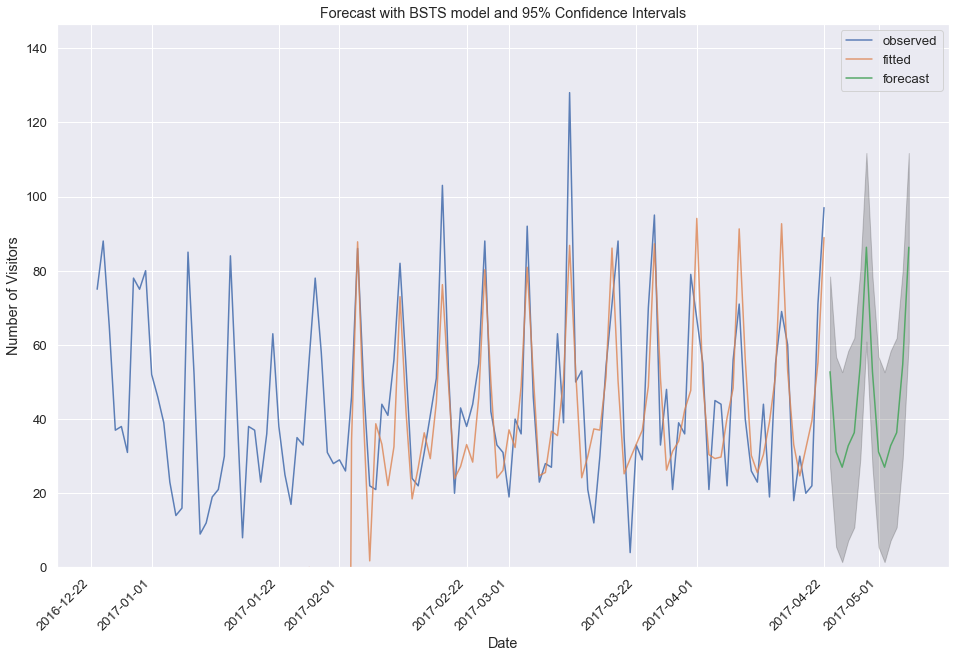

In [123]:
sns.lineplot(x='visit_date', y='visitors', data=most_final_full, label='observed', alpha=0.9)
sns.lineplot(x='visit_date', y='fitted', data=most_final_full, label='fitted', alpha=0.8)
sns.lineplot(x='visit_date', y='forecast', data=most_final_full, label='forecast')
ax = plt.gca()
ax.fill_between(most_final_full['visit_date'],
                most_final_full['95_lower'],
                most_final_full['95_upper'],
                color='k',
                alpha=0.2)
vfp.plot_config()
ax.set_ylim(bottom=0)
ax.set_ylabel('Number of Visitors')
ax.set_xlabel('Date')
ax.set_title('Forecast with {} model and 95% Confidence Intervals'.format(gbm_best_model.upper()))
plt.show()

The model starts to fit the data well after 3 seasons. It captures the overall pattern, but doesn't predict large deviations.

In [124]:
mf_final_full = vfm.make_forecast(
    most_df.loc[most_df['visit_day_name'].isin(most_day_names)].reset_index(),
    most_train_full.loc[most_train_full['visit_day_name'].isin(most_day_names), 'visitors'].values,
    'bsts',
    most_forecast_horizon,
    most_day_names,
    **most_params['bsts'])
assert mf_final_full.fillna(np.inf).eq(most_final_full.fillna(np.inf)).values.flatten().all()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


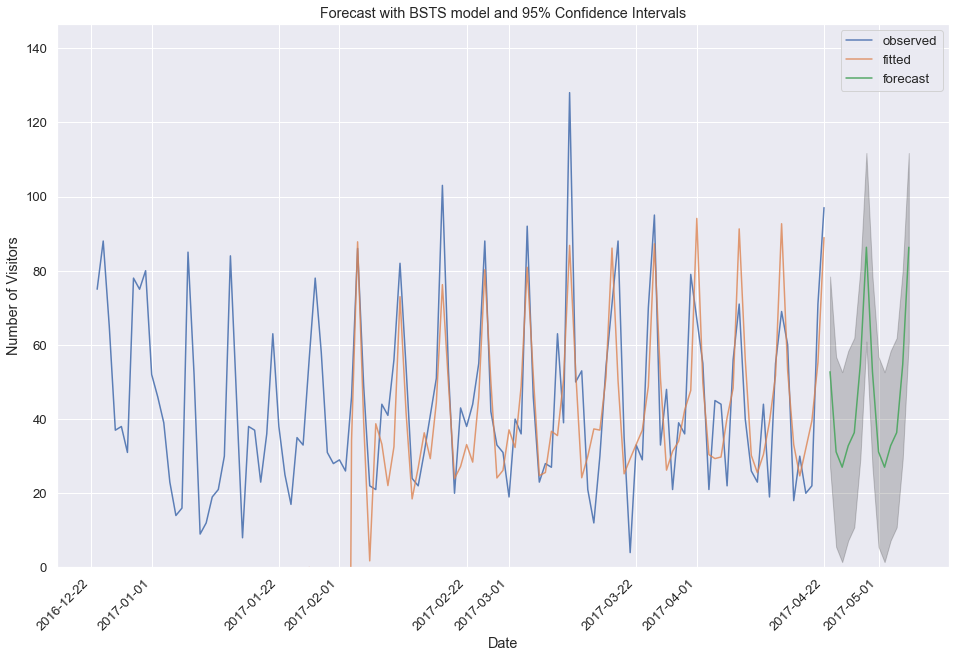

In [125]:
vfp.plot_forecast(mf_final_full, title='Forecast with {} model and 95% Confidence Intervals'.format(gbm_best_model.upper()))

### Modeling pipeline
I extract all of the steps needed to make a forecast into the `forecast_for_store` function.

In [126]:
ffs_final_full, ffs_audit = vfm.forecast_for_store(vfd.get_most_data_store_id(), most_forecast_horizon)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filte

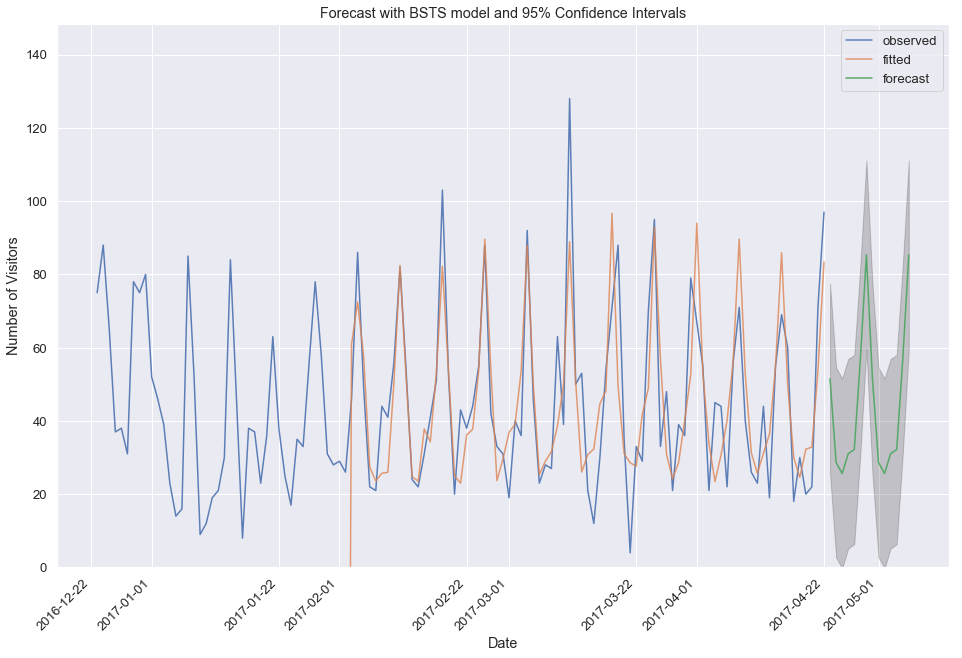

In [127]:
vfp.plot_forecast(ffs_final_full,
                  title='Forecast with {} model and 95% Confidence Intervals'.format(ffs_audit['best_model'].upper()))

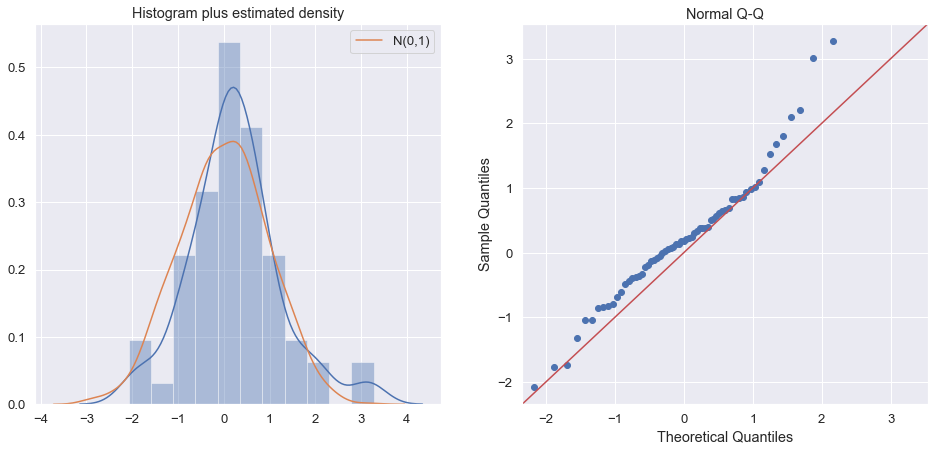

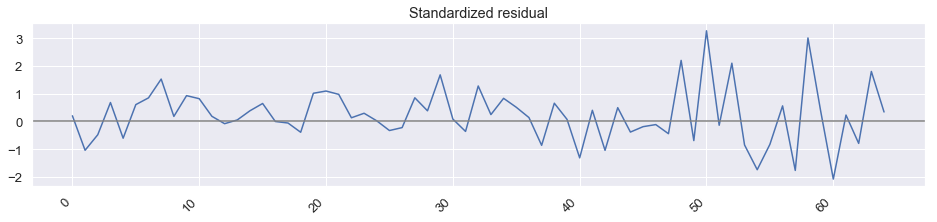

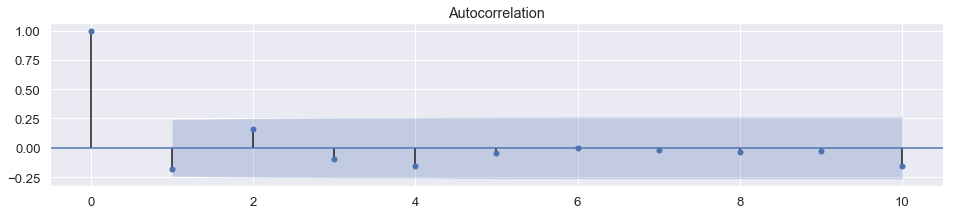

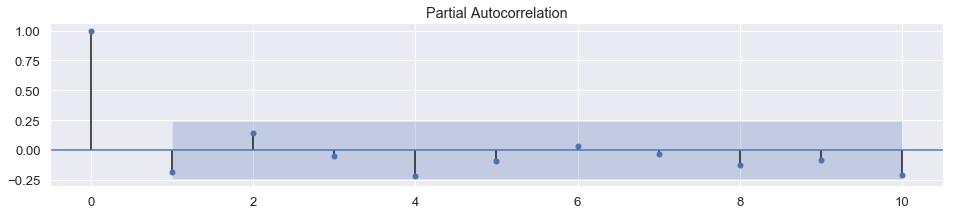

In [128]:
# use the cutoff to examine residuals after 3 seasons have passed
vfp.plot_rolling_window_analysis(ffs_audit['rolling_window_analysis'], ffs_audit['best_model'],
                                 cutoff=3*len(ffs_audit['day_names']))

The variance in residuals may increase near the end, but there doesn't seem to be a pattern in the residuals. The histogram and Q-Q plot indicate the distribution of residuals is heavy-tailed with more outliers than expected. Overall, the model has captured as much of the pattern in the data as it can.

### Examine restaurant with the least data

In [129]:
least_final_full, least_audit = vfm.forecast_for_store(vfd.get_least_data_store_id(), 14)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

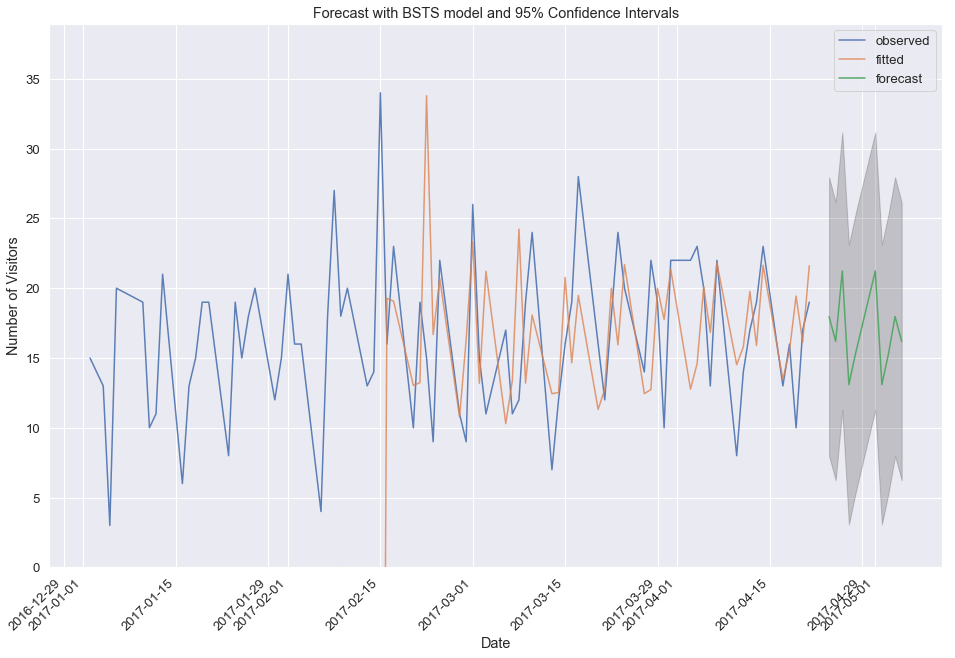

In [130]:
vfp.plot_forecast(least_final_full,
                  title='Forecast with {} model and 95% Confidence Intervals'.format(least_audit['best_model'].upper()))

The model consistently underestimates the peaks.

In [131]:
least_audit['rolling_window_analysis']

observed  forecast_error  \
2017-03-15  [16.0, 19.0, 28.0, 16.0, 12.0, 18.0, 24.0, 20....        0.660279   
2017-03-16  [19.0, 28.0, 16.0, 12.0, 18.0, 24.0, 20.0, 14....        0.646398   
2017-03-17  [28.0, 16.0, 12.0, 18.0, 24.0, 20.0, 14.0, 22....        0.719864   
2017-03-20  [16.0, 12.0, 18.0, 24.0, 20.0, 14.0, 22.0, 19....        0.595672   
2017-03-21  [12.0, 18.0, 24.0, 20.0, 14.0, 22.0, 19.0, 10....        0.962682   
2017-03-15  [16.0, 19.0, 28.0, 16.0, 12.0, 18.0, 24.0, 20....        0.590172   
2017-03-16  [19.0, 28.0, 16.0, 12.0, 18.0, 24.0, 20.0, 14....        0.600028   
2017-03-17  [28.0, 16.0, 12.0, 18.0, 24.0, 20.0, 14.0, 22....        0.907211   
2017-03-20  [16.0, 12.0, 18.0, 24.0, 20.0, 14.0, 22.0, 19....        0.600312   
2017-03-21  [12.0, 18.0, 24.0, 20.0, 14.0, 22.0, 19.0, 10....        0.676942   

                                              fitted_residual  \
2017-03-15  [1.8562473513838995e-06, 2.3195612701698565e-0...   
2017-03-16  [1.7324975285504252e-06, 2.1562118721618617e-0...   
2017-03-17  [1.6087477057169508e-06, 8.167452518748064e-07...   
2017-03-20  [3.712494707208691e-07, 2.711602945737468e-06,...   
2017-03-21  [2.474996470880342e-06, 3.1689781785360083e-06...   
2017-03-15  [13.0, -5.208613107303366, 11.791386892696634,...   
2017-03-16  [3.0, 11.83238553930046, 11.08238553930046, 10...   
2017-03-17  [20.0, 12.516315660162038, 12.266315660162038,...   
2017-03-20  [19.25, 12.233078640225902, 3.2330786402259024...   
2017-03-21  [19.0, 2.453904566950632, 3.453904566950632, 1...   

                                                     forecast    preview  \
2017-03-15  [19.33080959324709, 14.894741308220182, 19.448...  19.330810   
2017-03-16  [14.857150711301333, 19.46514102303587, 10.396...  14.857151   
2017-03-17  [19.591462016087085, 10.428639545774686, 14.46...  19.591462   
2017-03-20  [10.654665171139953, 14.579433555900055, 19.45...  10.654665   
2017-03-21  [14.708432887654986, 19.64939406121797, 16.383...  14.708433   
2017-03-15  [18.678416337771367, 16.58869005662745, 16.304...  18.678416   
2017-03-16  [16.587095754002345, 16.492123998871396, 14.60...  16.587096   
2017-03-17  [16.079208883365894, 14.416794984769759, 13.38...  16.079209   
2017-03-20  [13.85409250861931, 13.67268376206729, 15.2038...  13.854093   
2017-03-21  [13.996608500102418, 15.274616723968634, 18.27...  13.996609   

                    model  
2017-03-15     bsts_52_10  
2017-03-16     bsts_52_10  
2017-03-17     bsts_52_10  
2017-03-20     bsts_52_10  
2017-03-21     bsts_52_10  
2017-03-15  sarimax_50_10  
2017-03-16  sarimax_50_10  
2017-03-17  sarimax_50_10  
2017-03-20  sarimax_50_10  
2017-03-21  sarimax_50_10

In [132]:
least_audit['best_test_sle']

{'bsts': 0.9379030912088975, 'sarimax': 1.3061778828149635}

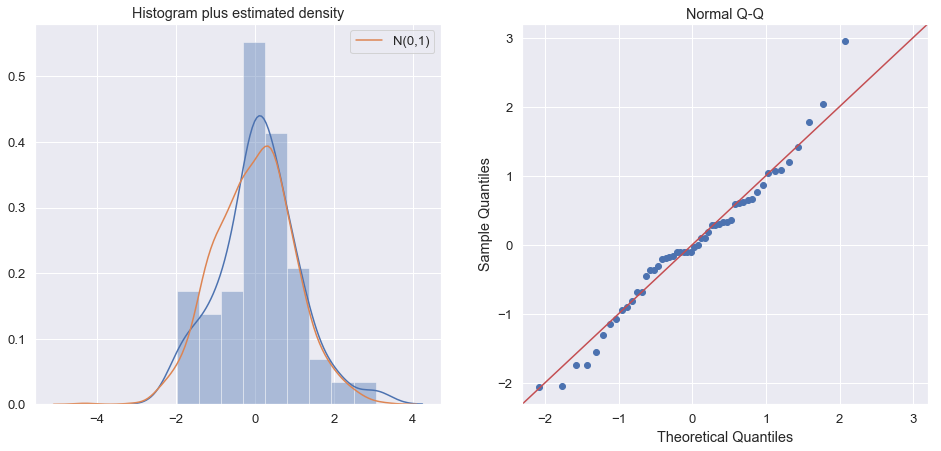

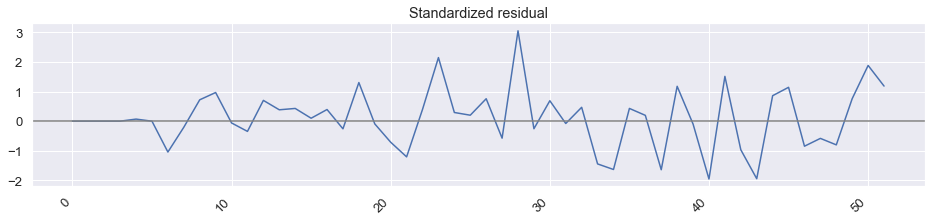

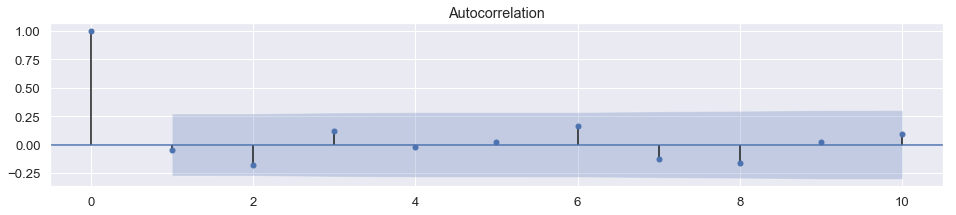

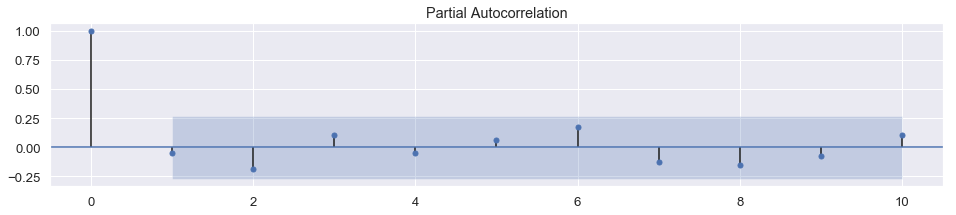

In [133]:
least_rwa = least_audit['rolling_window_analysis']
least_best_resids = least_rwa.loc[least_rwa['model'].str.contains('bsts'), 'fitted_residual'].values[-1]
vfp.plot_residuals(range(len(least_best_resids)), least_best_resids/np.std(least_best_resids))

The residuals are approximately normal. There doesn't seem to be a pattern in the residuals. Overall, the model has captured as much of the pattern in the data as it can.

# Conclusion
I have created these models using only historical data on the number of daily visitors. A model that can accurately forecast the future with only one feature would be valuable for its light demands on data collection. This advantage would appeal to independently-owned restaurants, which probably don’t have sophisticated data collection mechanisms in place as compared to franchises. 

The automatically fit models seem to capture as much of the pattern in the data as possible. The models assume constant variance in the data, so they aren't able to predict large deviations in the data. However, the confidence intervals reflect the possibility of large deviations so managers can adjust their forecasts.

The code in these two notebooks have been extracted into several python files. One of these files is `forecast.py`, which can be run from the command line to produce a forecast for a store in the dataset. A plot of the forecast is saved to `forecasts/figures` and a csv file of the forecasted values is saved to `forecasts/reports`. The script can be run given two inputs: the store id as `store` and the number of days to forecast `n`.

`python forecast.py [-h] store n`

Another file of interest is `vfmodel.py`, which contains the `forecast_for_store` function called by `forecast.py`. This function can be used in a production environment similar to how it is used in `forecast_for_store`. However, currently there are many assert statements throughout the files which make the code not robust in the event of errors. It would be best to remove the asserts or otherwise handle possible errors before using the code in a production environment. 

# Possible Enhancements
Currently the code requires two data files: `air_visit_data.csv` and `air_store_info.csv`. These would need to be updated daily with that day's visitor counts. Modifying the code to connect to a database with these counts instead would be better in the long run.

In `vfmodel.py`, the `get_window_size` and `rolling_window_analysis` functions fit models over many different windows. These functions could be parallelized to reduce runtime. I tried parallelizing with pySpark, but [user-defined functions on bounded windows](https://issues.apache.org/jira/browse/SPARK-24561) are not available in 2.4.0. They are in the works for version 3.0.0.